In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

Suggestion: try PLA on this dataset before using the bank dataset

In [2]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
y = [yy if yy == 1 else -1 for yy in y] 

In [3]:
def h(x,w):

    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [4]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [5]:
def decision_boundary(weights, x_min, x_max):
   # Return two points on the decision boundary
   return [point_on_boundary(weights, x_min), point_on_boundary(weights, x_max)]

In [6]:
def pla(training_in, training_out, weights):
    bias = np.array([1])
    iterations=0
    while True:
        print("\nIteration:", iterations)
        iterations+=1;
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                weights = weights + y*(np.concatenate((bias,x)))
                print("x:{} new weights:{} bias:{} errors:{}".format(x, weights, bias, errors))
                errors+=1;
        if (errors == 0):
            print("Hypothesis found. Nb iterations:", iterations)
            break
    return weights, iterations

In [7]:
def pla_with_pocket(training_in, training_out, weights, max_iterations):
    bias = np.array([1])
    iterations=0

    # init pocket algo variables
    best_weights = weights
    best_weights_iteration = 0
    lowest_nb_errors = -1;
    
    while iterations < max_iterations:
        print("\nIteration:", iterations)
        iterations+=1;

        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                
                weights = weights + y*(np.concatenate((bias,x)))
                print("x:{} new weights:{} bias:{} errors:{}".format(x, weights, bias, errors))
                errors+=1;
                
        # pocket best results
        if (errors < lowest_nb_errors or lowest_nb_errors == -1):
            best_weights = weights
            lowest_nb_errors = errors
            best_weights_iteration = iterations
            e = calc_error(training_in, training_out, best_weights)
            print("Pocketing new weights:{} e:{} errors:{} nb samples:{} iterations:{}".format(best_weights, e, lowest_nb_errors, len(training_in), best_weights_iteration))
            
        if (errors == 0):
            print("Hypothesis found. Nb iterations:", iterations)
            break
            
    return best_weights, best_weights_iteration, e, lowest_nb_errors, iterations 

In [8]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)

# Task 1

In [9]:
# Load the data
data = pd.read_csv("bank_et1.csv") 

In [10]:
# Preview the first 5 lines of the data 
data.head(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [11]:
# Preview the last 5 lines of the data
data.tail(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


## Target identification 

The dataset is compose of the following features:

| Feature name | description   | type |
|--------------|---------------|------|
|age           | age (numeric) | numeric |
|job           | job : type of job | categorical|
|marital|marital : marital status | categorical |
|education| education |categorical |
|default|default: has credit in default? |categorical|
|balance| account balance| numeric|
|ratio_bal_ln| ratio of balance to loan | numeric|
|ratio_ln_inc| ratio of loan to income | numeric|
|housing | has housing loan | categorical|
|loan | has personal loan | categorical|
|contact | contact communication type | categorical|
|day | day last contacted| numeric |
|month | month last contacted| numeric |
|duration | duration of last contact| numeric |
|campaign | number of contacts during this campaign| number |
|pdays | number of days since last contact| numeric|
|previous | number of contacts done in previous campaign| numeric|
|poutcome | outcome from previous campaign| categorical|
|subscribed | outcome from current campaign| categorical|

I believe the bank would be interested in predicting the outcome of a campaign based on the historical data it possesses.
For this reason I am selecting **subscribed** as my target.


# Task 2

## Calculate statistics for the numerical and categorical attributes

In [12]:
# Print statistical summary for all numerical attributes
data.describe()

,Unnamed: 0,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,577.494589,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,0.000000,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,499.750000,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,999.500000,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,1499.250000,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,1999.000000,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


In [13]:
data['job'].value_counts()


management       461
technician       348
blue-collar      298
admin.           247
services         165
retired          162
student           96
unemployed        69
self-employed     64
entrepreneur      45
housemaid         35
Name: job, dtype: int64

In [14]:
data['marital'].value_counts()

married     1111
single       674
divorced     215
Name: marital, dtype: int64

In [15]:
data['education'].value_counts()

secondary    995
tertiary     684
primary      217
Name: education, dtype: int64

In [16]:
data['default'].value_counts()

no     1985
yes      15
Name: default, dtype: int64

In [17]:
data['housing'].value_counts()

no     1037
yes     963
Name: housing, dtype: int64

In [18]:
data['loan'].value_counts()

no     1750
yes     250
Name: loan, dtype: int64

In [19]:
data['contact'].value_counts()

cellular     1663
telephone     146
Name: contact, dtype: int64

In [20]:
data['poutcome'].value_counts()

failure    955
success    444
other      147
Name: poutcome, dtype: int64

In [21]:
data['subscribed'].value_counts()

no     1000
yes    1000
Name: subscribed, dtype: int64

## Use at least two different plotting techniques to plot the distribution of two numerical and two categorical attributes

### Numerical attributes

Text(0,0.5,'Number of Customers')

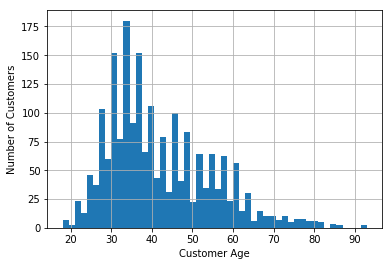

In [22]:
# Let's start by plotting a histogram of age :

data['age'].hist(bins=50)
plt.xlabel('Customer Age')
plt.ylabel('Number of Customers')

We can see that the customer base clearly represents the working class, with the 30-50 years old representing the bulk of the customers.

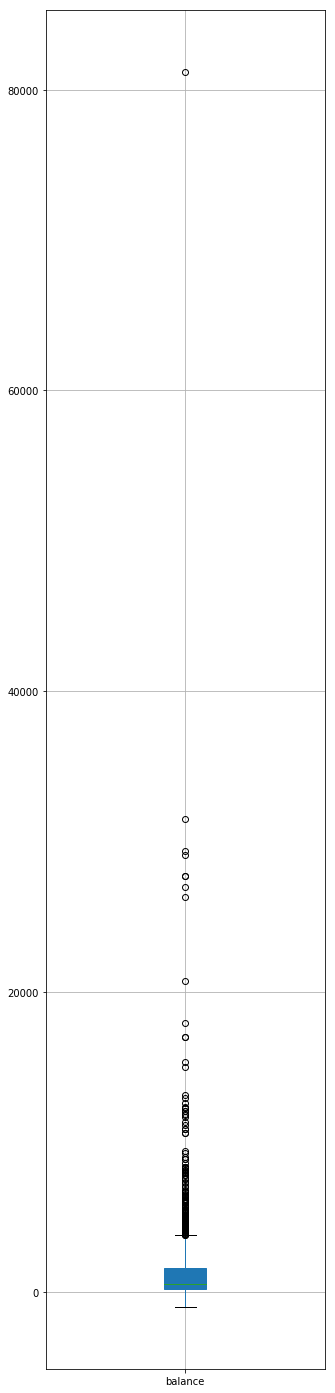

In [23]:
# Next, we look at boxplots of the balance.

data.boxplot(column='balance', figsize=(5,25), patch_artist = True)

The boxplot hightlight an outlier which is so high that it makes the Interquantile Range box very small and hard to read. 

### Categorical attributes

Text(0.5,0.98,'')

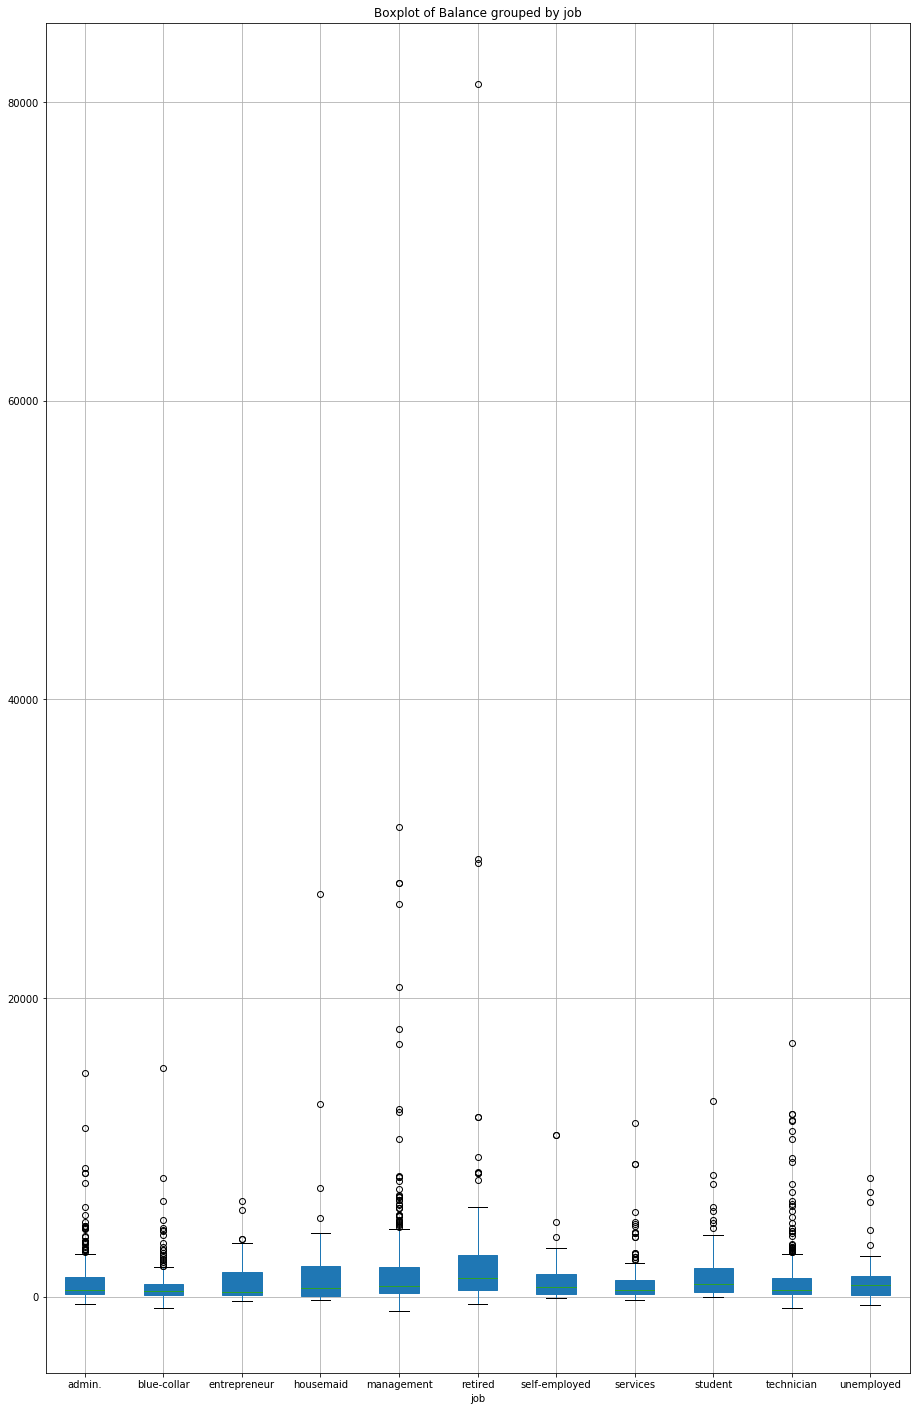

In [24]:
# Boxplots of "balance", grouped by the categorical attribute "job" to investigate which job category pays the best.
data.boxplot(column='balance', by='job', figsize=(15,25), patch_artist = True)

plt.title('Boxplot of Balance grouped by job')
plt.suptitle("") # get rid of the automatic 'Boxplot grouped by group_by_column_name' title

The boxplot carries a lot of information and a few interesting observations can be derived from it:
* The "retired" population is the wealthiest of all. There is an outliers that is so high that it would need further investigation to determine if it is an error or not.
* The average income for *entrepreneurs* is less than for *housemaids* and *unemployed* which is counter intuitive. 
* The *management* jobs tend to pay well with a good few outliers very well paid.

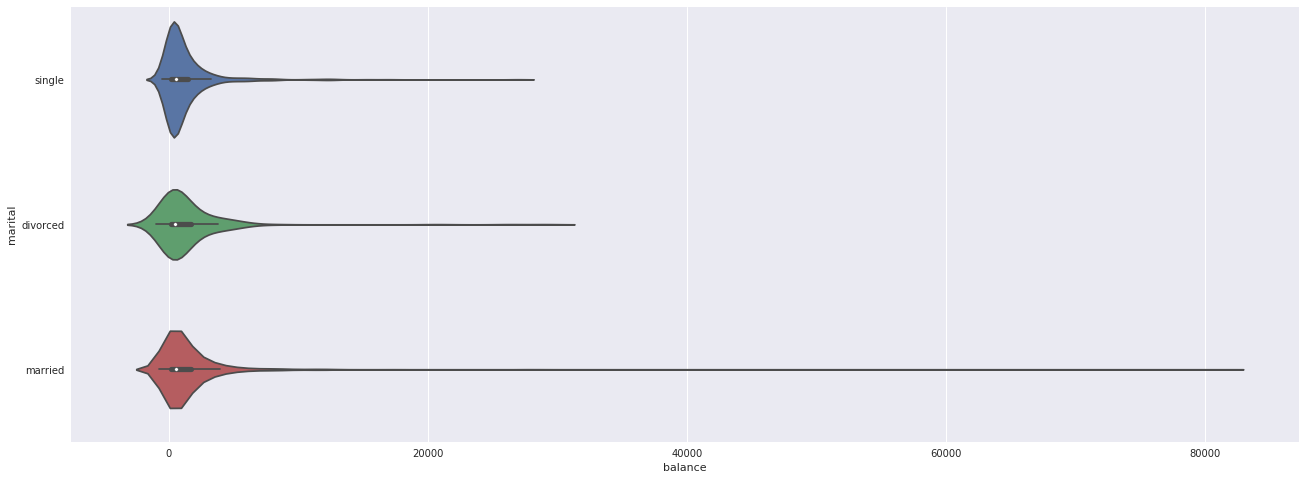

In [25]:
sns.set(rc={'figure.figsize':(22,8)})
sns.violinplot(x='balance', y='marital', data=data)

The violin diagram comparing the *balance* against the *marital status* shows that married people's balance is only marginally better than divorced people. Also it appears that the retired outlier identified in the previous graph is also married.

Frequency Table for job:
housemaid         35
entrepreneur      45
self-employed     64
unemployed        69
student           96
retired          162
services         165
admin.           247
blue-collar      298
technician       348
management       461
Name: job, dtype: int64


Text(0.5,1,'Customers by Job')

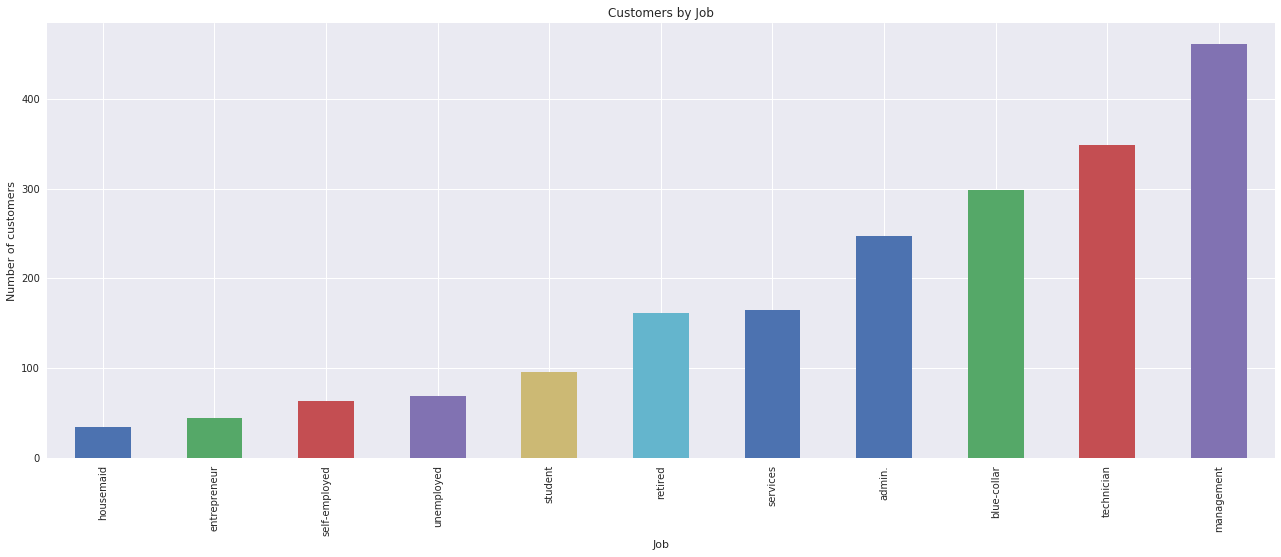

In [26]:
frequency_table = data['job'].value_counts(ascending=True)
print('Frequency Table for job:') 
print(frequency_table)
frequency_table.plot(kind='bar')
plt.xlabel('Job')
plt.ylabel('Number of customers')
plt.title('Customers by Job')

*Management* represents the highest job category before *technician*

**It seems that some job categories are missing**, such as: medical staff, teachers, engineers, and law enforcement to name a few. Could it be because they have been bundled under the wrong category? 

Text(0,0.5,'Number of Customers')

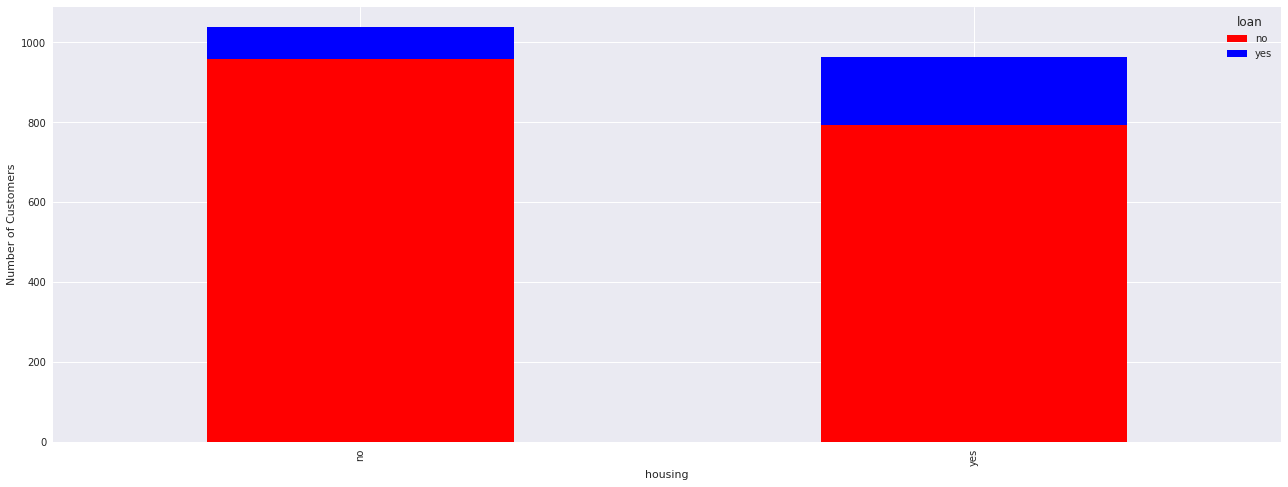

In [27]:
stacked_chart = pd.crosstab(data['housing'], data['loan'])
stacked_chart.plot(kind='bar', stacked=True, color=['red', 'blue'])
plt.ylabel('Number of Customers')

The above chart shows that customers who own a house are more than twice likely to have a loan. However, only about one fifth of the homeowner population has a loan which seems low.

Text(0,0.5,'Number of Customers')

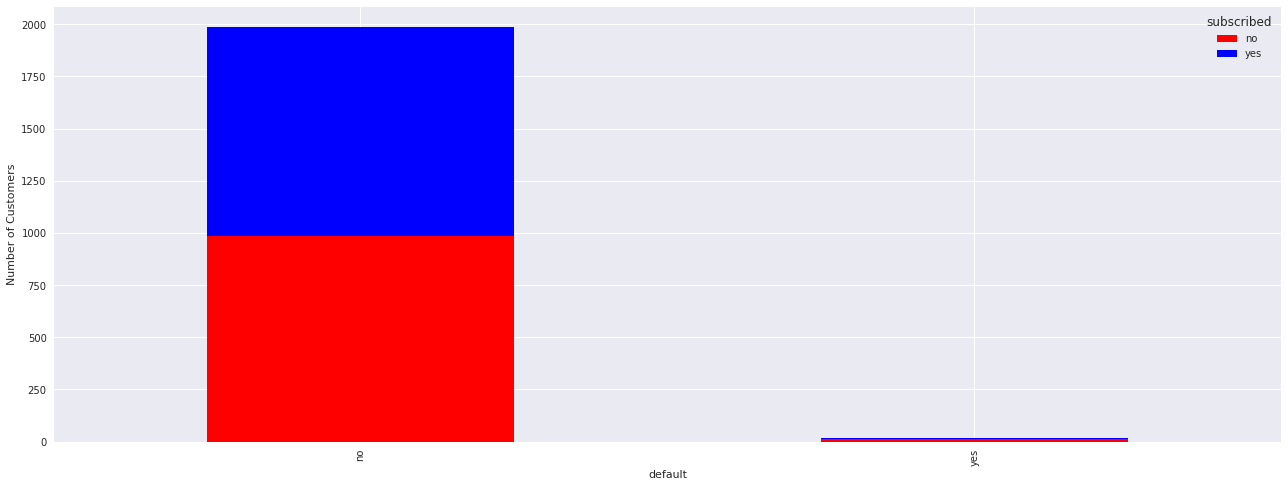

In [28]:
stacked_chart = pd.crosstab(data['default'], data['subscribed'])
stacked_chart.plot(kind='bar', stacked=True, color=['red', 'blue'])
plt.ylabel('Number of Customers')

The above diagram clearly shows that:
* 50% of the customer base is subscribed.
* There are very little defaulters in the customer base. Maybe defaulters accounts are being transferred to another agency.
* Defaulters are not *subscribed*.

## Generate two plots with the combined distribution of attributes

<span style="color:maroon">**Questions:**</span>

  * **Q1**: Do the plots below correspond to what we have been asked to produce?
  * **Q2**: Does combined distribution mean we need to use Pivot tables?

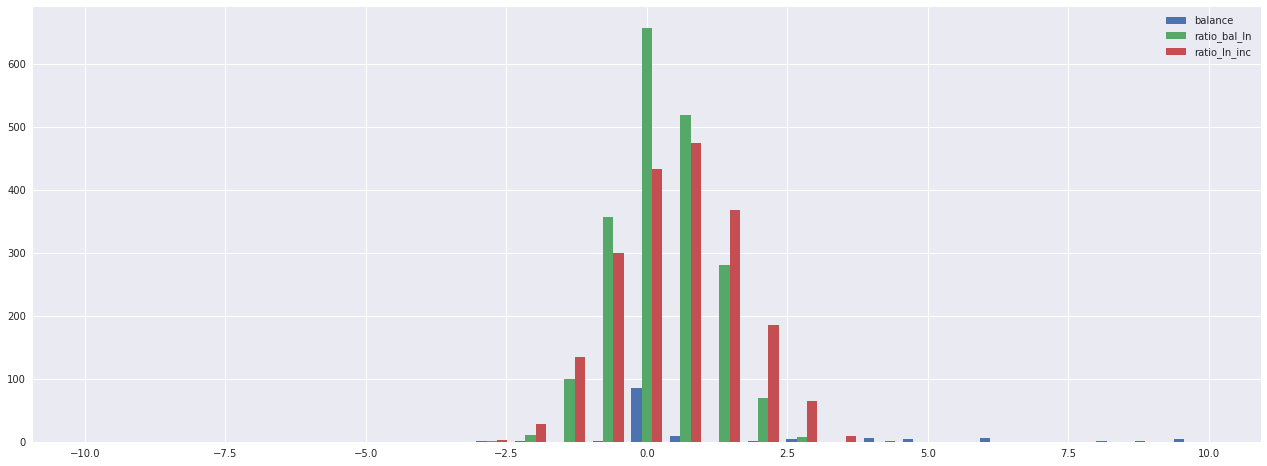

In [29]:

bins = np.linspace(-10, 10, 30)

plt.hist([data['balance'], data['ratio_bal_ln'], data['ratio_ln_inc']], bins, label=['balance', 'ratio_bal_ln', 'ratio_ln_inc'])
plt.legend(loc='upper right')
plt.show()

The above graph shows the distribution of the *balance*, *ratio_bal_ln* and *ratio_ln_inc* side by side and centered around their respective mean values.

The three distributions are gaussian in nature.

<span style="color:maroon">**Questions:**</span>

  * **Q1:** What do the values on the y axis represent? Is it the number of samples in each bin? If so, why is balance so low?
  * **Q2:** The distribution is gaussian when I use ```bins = np.linspace(-10, 10, 30)``` but not when I use ```bins = np.linspace(0, 10, 30)```. Why is that???


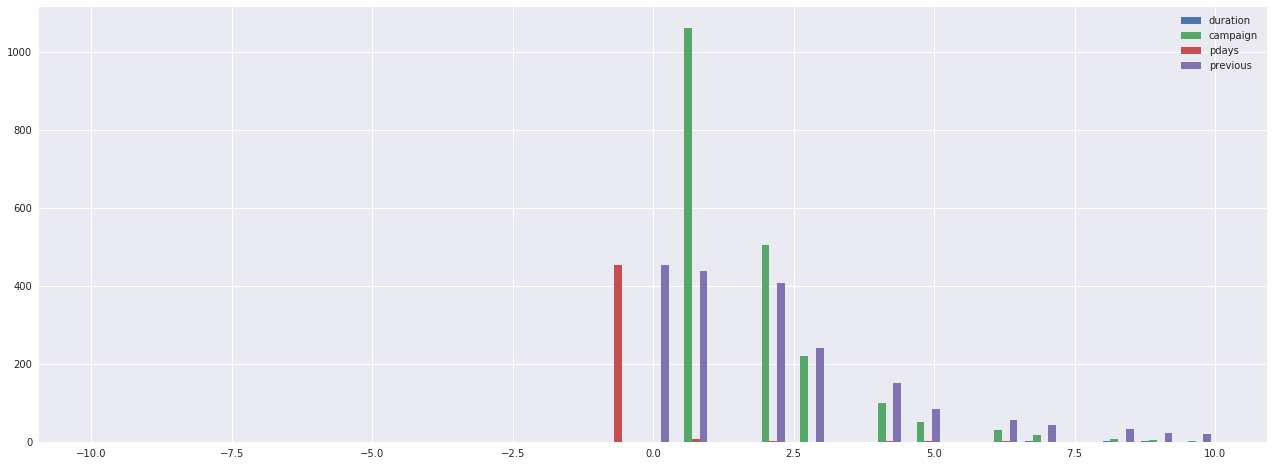

In [30]:

bins = np.linspace(-10, 10, 30)

plt.hist([data['duration'], data['campaign'], data['pdays'], data['previous']], bins, label=['duration', 'campaign', 'pdays', 'previous'])
plt.legend(loc='upper right')
plt.show()

The above graph shows the distribution of the *duration*, *campaign*, *pdays* and *previous* side by side and centered around their respective mean values.

The three distributions are gaussian in nature.

** Same questions as for previous graph.**

## Generate additional plots to indentify two numerical attributes that can potentially be used for predicting the value of the dependent variable chosen in task 1

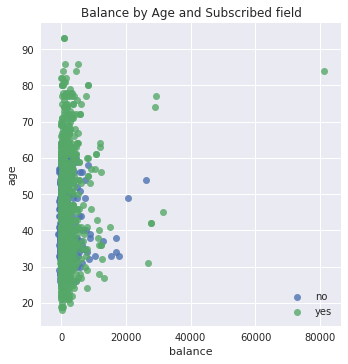

In [31]:
# Balance by Age by Subscribed.
sns.lmplot( x="balance", y="age", data=data, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("Balance by Age and Subscribed field")
plt.legend(loc='lower right')


Using the *age* and *balance* features will **not allow** us to separate the "yes" and "no" *subscription* clusters as they are overlapping.

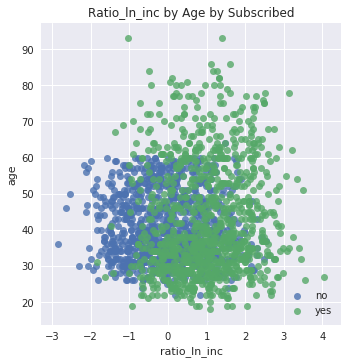

In [32]:
# Ratio_ln_inc by Age by Subscribed
sns.lmplot( x="ratio_ln_inc", y="age", data=data, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("Ratio_ln_inc by Age by Subscribed")
plt.legend(loc='lower right')

The above graph shows 2 clusters with a significant overlap. The distribution of the green point is very spread out which would negatively affect the possibility for PLA to converge.

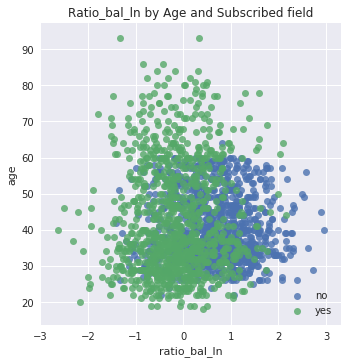

In [33]:
# Ratio_bal_ln by Age by Subscribed.
sns.lmplot( x="ratio_bal_ln", y="age", data=data, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("Ratio_bal_ln by Age and Subscribed field")
plt.legend(loc='lower right')

The scatter plot shows 2 clusters with a significant overlap and a very spread out "yes" distribution. **Learning will be difficult.**

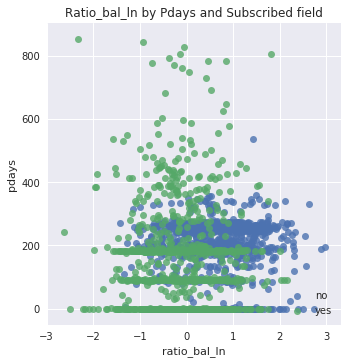

In [34]:
# Ratio_bal_ln by Pdays and Subscribed field
sns.lmplot( x="ratio_bal_ln", y="pdays", data=data, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("Ratio_bal_ln by Pdays and Subscribed field")
plt.legend(loc='lower right')

The graph clearly shows the impact of the marketing campaigns on the level of subscriptions which is highlighted by 3 horizontal green lines.

  * **Day 0 subscriptions**: This probably corresponds to the day the customers open an account with the bank. During that process, the bank employee probably up-sales as much as possible resulting in a significant uptake in subscriptions. 

  * **Day 100 subscriptions**: This is probably the result of a phone marketing campaign.

  * **Day 200 subscriptions**: This is probably the result of a phone marketing campaign. 
  
  
Unfortunately, these features do not allow us to create 2 separable clusters and therefore **could not be used for learning**.

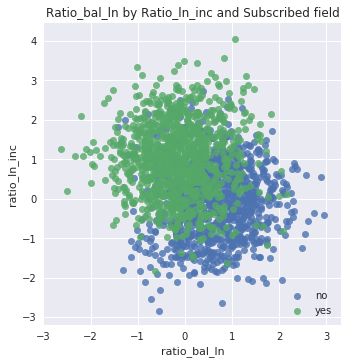

In [35]:
# Ratio_bal_ln by Ratio_ln_inc and Subscribed field
sns.lmplot( x="ratio_bal_ln", y="ratio_ln_inc", data=data, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("Ratio_bal_ln by Ratio_ln_inc and Subscribed field")
plt.legend(loc='lower right')

*ratio_bal_ln* and *ratio_ln_inc* are Key Performance Indicators for an account and each one of these KPIs links 2 features. 

  * the *ratio_bal_ln* ratio links the balance to a loan value. 
  * the *ratio_ln_inc* ratio links a loan value to an income.
  
**Because these KPIs are rich in information, I believe they could be prime candidates for our input features.**

However, the scatter plot clearly shows 2 significantly overlapping clusters, which means that **learning will be difficult.**

# Task 3

Let’s consider a dataset composed of 2000 historical data records relating to a bank marketing campaign from which we want to extract a 2-dimensional **input space** that can successfully be used to predict an **output space** representing the subscription rate for a new product. 

Let’s choose two important key performance indicators (KPIs) for the input space: the ratio balance to loan and the ratio loan to income.  These KPIs condense a lot of information and are expected to be good candidates for our leaning algorithm which aims to identify a function approximating an **unknown target function** which links the input space to the output space. 

We use the Perceptron algorithm (with pocket) to identify a **Hypothesis set** from which we extract the most suited function which we refer to as the **Final hypothesis.** 

The Perceptron Learning Algorithm (PLA) is a best suited to learn from data that are linearly separable. It takes an input, aggregates it using weights and returns 1 if the aggregated sum is more than some threshold (bias) or else it returns -1. The main goal of the Perceptron is to learn weights that represent a line which can be used to separate clusters of data. The learning of the weight involves updating them each time the target isn't met. 

Once we have run the PLA or Pocket algorithm on the dataset, we compare the margins between the **in-sample error** and the **out-sample** error against the Hoeffding bound and determine if learning is indeed possible. 

# Task 4

## Running the PLA against the sample dataset generated with make_blobs()

In [36]:
# Run the PLA against the sample dataset
print(X)
print(y)
w = [1,1,1]
weights = np.array(w)

pla(X, y, weights)

[[-5.60120572  4.36456959]
 [-0.73216942 -3.23552842]
 [-5.60020596  7.16641655]
 ...
 [-7.62355647  7.72434654]
 [-1.10479519 -3.35143221]
 [-1.35727697 -5.01060505]]
[-1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1

(array([ 2.        ,  0.26783058, -2.23552842]), 2)

The PLA sometimes converge on the first iteration, sometimes it does not converge at all. **TODO: explain why**

The PLA can be improved as follows:
  * Implement the pocket algorithm which stores a copy of the best weight and error tuple.
  * Implement a parameter which controls how many times the PLA is executed.

## Running an improved version of PLA against the bank dataset

In [37]:
# Start by converting "subscribed" target from "yes/no" to "1/-1"
data['subscribed_code'] = data['subscribed'].map({'yes': 1, 'no': -1})
data[["subscribed", "subscribed_code"]].head(5)

,subscribed,subscribed_code
0,no,-1
1,no,-1
2,no,-1
3,no,-1
4,no,-1


In [38]:
data[["subscribed", "subscribed_code"]].tail(5)

,subscribed,subscribed_code
1995,yes,1
1996,yes,1
1997,yes,1
1998,yes,1
1999,yes,1


I note that the values used for initializing the weights have an impact on the number of iterations needed to find the lowest error. In particalar, it looks like using low values for the weight is most efficient.

In [39]:
# Apply PLA with pocket algorithm on banking data

# Initiatialise the weights with random values
weights = np.array([-10,0,10])

# Use 'ratio_bal_ln' and 'ratio_ln_inc' as our inputs
X = data[['ratio_bal_ln', 'ratio_ln_inc']].values

# Use 'subscribed_code' as the target
y = data['subscribed_code'].values

# Number of iterations before exiting the PLA algorithm.
max_iterations = 1000

best_weights, best_weights_iteration, e, lowest_nb_errors, iterations = pla_with_pocket(X, y, weights, max_iterations)
print("\nBest weights:{} with e:{} lowest nb errors:{} found after {} iterations out of a total of {} iterations.".format(best_weights, e, lowest_nb_errors, best_weights_iteration, iterations))


Iteration: 0
x:[0.36228555 1.25132834] new weights:[-11.          -0.36228555   8.74867166] bias:[1] errors:0
x:[0.59287054 1.55097938] new weights:[-12.          -0.95515609   7.19769228] bias:[1] errors:1
x:[0.89871006 2.31867514] new weights:[-13.          -1.85386615   4.87901714] bias:[1] errors:2
x:[-0.22003241  1.63822905] new weights:[-12.          -2.07389856   6.51724619] bias:[1] errors:3
x:[0.79126643 1.26598001] new weights:[-11.          -1.28263213   7.7832262 ] bias:[1] errors:4
x:[0.65306618 1.18059696] new weights:[-10.          -0.62956595   8.96382316] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[-9.          0.53316549  9.15264219] bias:[1] errors:6
x:[0.53159712 0.74690002] new weights:[-8.          1.06476262  9.8995422 ] bias:[1] errors:7
x:[-0.09736177  0.46375902] new weights:[-7.          0.96740085 10.36330123] bias:[1] errors:8
x:[-0.07753608 -0.20688202] new weights:[-6.          0.88986477 10.15641921] bias:[1] errors:9
x:[-1.09297896 -0.0982

Pocketing new weights:[4.         0.92953677 2.31099969] e:0.49 errors:11 nb samples:2000 iterations:6

Iteration: 6
x:[1.30013442 0.47389512] new weights:[ 3.         -0.37059765  1.83710456] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.17689638  1.60008345] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -1.51116239  1.47810226] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -1.87344794  0.22677393] bias:[1] errors:3
x:[0.02264785 0.72422694] new weights:[-1.         -1.89609579 -0.49745301] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.17120684  0.50115194] bias:[1] errors:5
x:[-1.41888838  1.80997663] new weights:[-3.          0.24768155 -1.30882469] bias:[1] errors:6
x:[ 1.42585939 -2.07489823] new weights:[-4.         -1.17817784  0.76607354] bias:[1] errors:7
x:[-0.22003241  1.63822905] new weights:[-3.         -1.39821025  2.40430258] bias:[1] errors:8
x:[0.79126643 1.26598001] n

x:[-1.41888838  1.80997663] new weights:[-3.          0.23477943 -1.47749195] bias:[1] errors:5
x:[ 1.42585939 -2.07489823] new weights:[-4.         -1.19107996  0.59740628] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-3.         -1.41111237  2.23563532] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.         -0.61984594  3.50161533] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[-1.          0.54288551  3.69043436] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.         0.46534943 3.48355234] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.62762952  3.38527915] bias:[1] errors:11
x:[ 0.70206726 -0.22290362] new weights:[2.         0.07443774 3.16237553] bias:[1] errors:12
x:[-0.06817614 -0.94342111] new weights:[3.         0.0062616  2.21895442] bias:[1] errors:13
x:[-0.07931597 -1.3745943 ] new weights:[ 4.         -0.07305437  0.84436011] bias:[1] errors:14

Iteration: 18
x:[1.30013442 0.47389512] new wei

x:[0.36228555 1.25132834] new weights:[ 1.         -2.75212488 -0.88386161] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -2.82420009 -0.35012411] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-1.         -2.09931114  0.64848085] bias:[1] errors:4
x:[-1.13850634 -1.48134218] new weights:[-2.         -0.9608048   2.12982303] bias:[1] errors:5
x:[-1.19728934  1.0994542 ] new weights:[-3.          0.23648454  1.03036883] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-2.          0.01645213  2.66859788] bias:[1] errors:7
x:[1.16273144 0.18881903] new weights:[-1.          1.17918358  2.85741691] bias:[1] errors:8
x:[-0.07753608 -0.20688202] new weights:[0.         1.1016475  2.65053489] bias:[1] errors:9
x:[-1.09297896 -0.09827319] new weights:[1.         0.00866854 2.5522617 ] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.0595076   1.60884059] bias:[1] errors:11
x:[-0.07931597 -1.3745943 ] new weights:[ 3.    


Iteration: 43
x:[1.30013442 0.47389512] new weights:[ 2.         -1.42013816 -0.24809255] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.22643689 -0.48511366] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.2985121   0.04862384] bias:[1] errors:2
x:[0.02264785 0.72422694] new weights:[-1.         -1.32115995 -0.6756031 ] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.596271    0.32300186] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -0.81630341  1.9612309 ] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[0.         0.34642803 2.15004994] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[1.         0.26889196 1.94316792] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[2.         0.20071581 0.9997468 ] bias:[1] errors:8

Iteration: 44
x:[1.30013442 0.47389512] new weights:[ 1.         -1.09941861  0.52585168] bias:[1] errors:0
x:[-0.19370127  0.23702111]

x:[-0.22003241  1.63822905] new weights:[-1.         -0.88818499  1.72432516] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[0.         0.27454646 1.91314419] bias:[1] errors:5
x:[-0.07753608 -0.20688202] new weights:[1.         0.19701038 1.70626217] bias:[1] errors:6
x:[-0.06817614 -0.94342111] new weights:[2.         0.12883424 0.76284106] bias:[1] errors:7

Iteration: 57
x:[1.30013442 0.47389512] new weights:[ 1.         -1.17130018  0.28894594] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 0.         -0.97759891  0.05192483] bias:[1] errors:1
x:[0.02264785 0.72422694] new weights:[-1.         -1.00024676 -0.67230211] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.27535781  0.32630285] bias:[1] errors:3
x:[-0.22003241  1.63822905] new weights:[-1.         -0.49539022  1.9645319 ] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[0.         0.66734122 2.15335093] bias:[1] errors:5
x:[-0.07753608 -0.20688202] new weights:[1.  

x:[-0.22003241  1.63822905] new weights:[-1.         -0.42994355  2.0421327 ] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[0.         0.7327879  2.23095173] bias:[1] errors:5
x:[-0.07753608 -0.20688202] new weights:[1.         0.65525182 2.02406971] bias:[1] errors:6
x:[-0.06817614 -0.94342111] new weights:[2.         0.58707568 1.0806486 ] bias:[1] errors:7
x:[-0.62447716 -1.83741009] new weights:[ 3.         -0.03740148 -0.75676149] bias:[1] errors:8

Iteration: 72
x:[1.30013442 0.47389512] new weights:[ 2.         -1.3375359  -1.23065661] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.14383463 -1.46767772] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.21590984 -0.93394022] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.49102089  0.06466474] bias:[1] errors:3
x:[-0.22003241  1.63822905] new weights:[ 0.         -0.7110533   1.70289379] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:

x:[-0.19370127  0.23702111] new weights:[ 2.         -1.17985336  0.43597217] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.51411938  0.31399098] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -2.87640492 -0.93733736] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -2.94848013 -0.40359986] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -2.22359118  0.5950051 ] bias:[1] errors:5
x:[-1.19728934  1.0994542 ] new weights:[-3.         -1.02630184 -0.5044491 ] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-2.         -1.24633425  1.13377995] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.         -0.45506782  2.39975996] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         0.70766363 2.58857899] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[1.         0.63012755 2.38169697] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[2.         0

x:[-0.07931597 -1.3745943 ] new weights:[ 4.         -0.3406171   2.26062054] bias:[1] errors:15

Iteration: 99
x:[1.30013442 0.47389512] new weights:[ 3.         -1.64075152  1.78672542] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.44705025  1.54970431] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.78131626  1.42772312] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -3.14360181  0.17639479] bias:[1] errors:3
x:[0.02264785 0.72422694] new weights:[-1.         -3.16624966 -0.54783215] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.        -2.4413607  0.4507728] bias:[1] errors:5
x:[-1.13850634 -1.48134218] new weights:[-3.         -1.30285436  1.93211499] bias:[1] errors:6
x:[-1.19728934  1.0994542 ] new weights:[-4.         -0.10556503  0.83266079] bias:[1] errors:7
x:[-0.22003241  1.63822905] new weights:[-3.         -0.32559744  2.47088983] bias:[1] errors:8
x:[0.79126643 1.26598001] new weigh


Iteration: 112
x:[1.30013442 0.47389512] new weights:[ 2.         -1.54024565  0.85511245] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.34654438  0.61809134] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.70882993 -0.633237  ] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.78090514 -0.0994995 ] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.05601618  0.89910546] bias:[1] errors:4
x:[-1.19728934  1.0994542 ] new weights:[-3.          0.14127316 -0.20034874] bias:[1] errors:5
x:[-0.22003241  1.63822905] new weights:[-2.         -0.07875926  1.43788031] bias:[1] errors:6
x:[0.79126643 1.26598001] new weights:[-1.          0.71250718  2.70386032] bias:[1] errors:7
x:[-0.07753608 -0.20688202] new weights:[0.        0.6349711 2.4969783] bias:[1] errors:8
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.45800785  2.3987051 ] bias:[1] errors:9
x:[-0.06817614 -0.94342111] new weig


Iteration: 125
x:[1.30013442 0.47389512] new weights:[ 3.         -0.70625787 -0.26706388] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.51255661 -0.50408498] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -1.84682262 -0.62606618] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.91889783 -0.09232867] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-1.         -1.19400887  0.90627628] bias:[1] errors:4
x:[-1.19728934  1.0994542 ] new weights:[-2.          0.00328046 -0.19317791] bias:[1] errors:5
x:[-0.22003241  1.63822905] new weights:[-1.         -0.21675195  1.44505113] bias:[1] errors:6
x:[1.16273144 0.18881903] new weights:[0.         0.9459795  1.63387016] bias:[1] errors:7
x:[-0.07753608 -0.20688202] new weights:[1.         0.86844342 1.42698814] bias:[1] errors:8
x:[-1.09297896 -0.09827319] new weights:[ 2.         -0.22453553  1.32871495] bias:[1] errors:9
x:[ 0.9005461  -1.62720375] new weig

x:[-0.22003241  1.63822905] new weights:[-2.         -1.09335901  0.89839954] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.         -0.30209258  2.16437955] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         0.86063887 2.35319858] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[1.         0.78310279 2.14631656] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[ 2.         -0.30987616  2.04804337] bias:[1] errors:11
x:[-0.07931597 -1.3745943 ] new weights:[ 3.         -0.38919213  0.67344907] bias:[1] errors:12

Iteration: 139
x:[1.30013442 0.47389512] new weights:[ 2.         -1.68932655  0.19955394] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.49562528 -0.03746716] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.85791083 -1.2887955 ] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.92998604 -0.755058  ] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new wei

x:[-0.62447716 -1.83741009] new weights:[ 3.         -0.34973439 -0.61759987] bias:[1] errors:8

Iteration: 150
x:[1.30013442 0.47389512] new weights:[ 2.         -1.64986882 -1.091495  ] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.45616755 -1.3285161 ] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.52824276 -0.7947786 ] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.8033538   0.20382636] bias:[1] errors:3
x:[-1.19728934  1.0994542 ] new weights:[-2.          0.39393554 -0.89562784] bias:[1] errors:4
x:[ 1.79752799 -1.50647774] new weights:[-3.         -1.40359245  0.6108499 ] bias:[1] errors:5
x:[-1.41888838  1.80997663] new weights:[-4.          0.01529593 -1.19912674] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-3.         -0.20473648  0.43910231] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.          0.58652995  1.70508232] bias:[1] errors:8
x:[1.16273144 0.18881903] ne

x:[-0.07753608 -0.20688202] new weights:[0.         1.35970467 3.8622835 ] bias:[1] errors:9
x:[-1.09297896 -0.09827319] new weights:[1.         0.26672572 3.76401031] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[2.         0.19854957 2.8205892 ] bias:[1] errors:11
x:[-0.21168609 -0.77557959] new weights:[ 3.         -0.01313651  2.04500961] bias:[1] errors:12
x:[ 0.17281567 -1.4754844 ] new weights:[4.         0.15967916 0.56952521] bias:[1] errors:13

Iteration: 160
x:[1.30013442 0.47389512] new weights:[ 3.         -1.14045526  0.09563009] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.94675399 -0.14139102] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.28102001 -0.26337221] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -2.35309522  0.2703653 ] bias:[1] errors:3
x:[0.02264785 0.72422694] new weights:[-1.         -2.37574307 -0.45386164] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weight

x:[-0.07753608 -0.20688202] new weights:[1.         1.1924322  2.33902582] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[2.         0.09945325 2.24075263] bias:[1] errors:11
x:[-0.06817614 -0.94342111] new weights:[3.         0.0312771  1.29733152] bias:[1] errors:12

Iteration: 170
x:[1.30013442 0.47389512] new weights:[ 2.         -1.26885732  0.8234364 ] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.07515605  0.58641529] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.4374416  -0.66491305] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.50951681 -0.13117554] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.78462785  0.86742941] bias:[1] errors:4
x:[-0.11255858  2.49609278] new weights:[-3.         -0.67206927 -1.62866337] bias:[1] errors:5
x:[-1.3213388  -1.80536105] new weights:[-4.          0.64926952  0.17669768] bias:[1] errors:6
x:[-0.22003241  1.63822905] new we


Iteration: 182
x:[1.30013442 0.47389512] new weights:[ 2.         -1.05583204  0.00780248] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -0.86213078 -0.22921863] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.22441632 -1.48054696] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.29649153 -0.94680946] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.57160258  0.0517955 ] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -0.79163499  1.69002454] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[0.         0.37109645 1.87884357] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[1.         0.29356038 1.67196155] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[2.         0.22538423 0.72854044] bias:[1] errors:8

Iteration: 183
x:[1.30013442 0.47389512] new weights:[ 1.         -1.07475019  0.25464532] bias:[1] errors:0
x:[-0.19370127  0.2370211

x:[-1.3213388  -1.80536105] new weights:[-4.         -0.19053888  1.0994819 ] bias:[1] errors:5
x:[-0.22003241  1.63822905] new weights:[-3.         -0.41057129  2.73771095] bias:[1] errors:6
x:[0.65306618 1.18059696] new weights:[-2.          0.24249489  3.91830791] bias:[1] errors:7
x:[1.16273144 0.18881903] new weights:[-1.          1.40522633  4.10712694] bias:[1] errors:8
x:[-0.07753608 -0.20688202] new weights:[0.         1.32769026 3.90024492] bias:[1] errors:9
x:[-1.09297896 -0.09827319] new weights:[1.         0.2347113  3.80197173] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[2.         0.16653516 2.85855062] bias:[1] errors:11
x:[-0.21168609 -0.77557959] new weights:[ 3.         -0.04515093  2.08297103] bias:[1] errors:12
x:[ 0.17281567 -1.4754844 ] new weights:[4.         0.12766474 0.60748663] bias:[1] errors:13

Iteration: 196
x:[1.30013442 0.47389512] new weights:[ 3.         -1.17246968  0.13359151] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weight


Iteration: 205
x:[1.30013442 0.47389512] new weights:[ 2.         -1.41098716 -0.24929168] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.21728589 -0.48631279] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.2893611   0.04742472] bias:[1] errors:2
x:[0.02264785 0.72422694] new weights:[-1.         -1.31200895 -0.67680222] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.58711999  0.32180273] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -0.8071524   1.96003178] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[0.         0.35557904 2.14885081] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[1.         0.27804296 1.94196879] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[2.         0.20986682 0.99854768] bias:[1] errors:8

Iteration: 206
x:[1.30013442 0.47389512] new weights:[ 1.         -1.0902676   0.52465256] bias:[1] errors:0
x:[-0.19370127  0.2370211

x:[-2.63206847  1.25683733] new weights:[ 1.         -0.83454537  4.83607611] bias:[1] errors:12
x:[ 0.70206726 -0.22290362] new weights:[ 2.         -0.13247811  4.61317249] bias:[1] errors:13
x:[-0.06817614 -0.94342111] new weights:[ 3.         -0.20065426  3.66975138] bias:[1] errors:14
x:[-0.07931597 -1.3745943 ] new weights:[ 4.         -0.27997023  2.29515707] bias:[1] errors:15
x:[-0.62447716 -1.83741009] new weights:[ 5.         -0.90444738  0.45774698] bias:[1] errors:16

Iteration: 215
x:[1.30013442 0.47389512] new weights:[ 4.         -2.2045818  -0.01614814] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 3.         -2.01088054 -0.25316925] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 2.         -3.34514655 -0.37515044] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 1.         -3.7074321  -1.62647877] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -3.77950731 -1.09274127] bias:[1] errors:4
x:[-0.72488895 -0.9986049


Iteration: 223
x:[1.30013442 0.47389512] new weights:[ 2.         -1.73306567 -0.05321969] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.53936441 -0.2902408 ] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.90164995 -1.54156914] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.97372516 -1.00783163] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.24883621 -0.00922668] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -1.46886862  1.62900237] bias:[1] errors:5
x:[0.79126643 1.26598001] new weights:[ 0.         -0.67760219  2.89498238] bias:[1] errors:6
x:[1.16273144 0.18881903] new weights:[1.         0.48512926 3.08380141] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[2.         0.41695311 2.1403803 ] bias:[1] errors:8
x:[-0.07931597 -1.3745943 ] new weights:[3.         0.33763715 0.76578599] bias:[1] errors:9

Iteration: 224
x:[1.30013442 0.47389512]


Iteration: 232
x:[1.30013442 0.47389512] new weights:[ 3.         -1.22075898  0.43946914] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.02705771  0.20244803] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.36132373  0.08046684] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -2.72360927 -1.17086149] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -2.79568448 -0.63712399] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -2.07079553  0.36148097] bias:[1] errors:5
x:[-1.19728934  1.0994542 ] new weights:[-3.         -0.87350619 -0.73797323] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-2.         -1.0935386   0.90025581] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.         -0.30227217  2.16623582] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         0.86045928 2.35505485] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weigh

x:[1.30013442 0.47389512] new weights:[ 2.         -1.39944787  0.26072179] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.2057466   0.02370069] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.56803215 -1.22762765] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.64010736 -0.69389015] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.91521841  0.30471481] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -1.13525082  1.94294385] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[0.         0.02748063 2.13176288] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[ 1.         -0.05005545  1.92488087] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.11823159  0.98145975] bias:[1] errors:8

Iteration: 243
x:[1.30013442 0.47389512] new weights:[ 1.         -1.41836601  0.50756463] bias:[1] errors:0
x:[-0.19370127  0.23702111] new wei

x:[-0.07931597 -1.3745943 ] new weights:[3.         0.29495703 0.43714874] bias:[1] errors:13

Iteration: 252
x:[1.30013442 0.47389512] new weights:[ 2.         -1.00517739 -0.03674638] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -0.81147612 -0.27376749] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.17376167 -1.52509583] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.24583688 -0.99135832] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.52094792  0.00724663] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -0.74098034  1.64547568] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[0.         0.42175111 1.83429471] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[1.         0.34421503 1.62741269] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[2.         0.27603889 0.68399158] bias:[1] errors:8

Iteration: 253
x:[1.30013442 0.47389512]

x:[-1.3213388  -1.80536105] new weights:[-4.          0.34089356  0.61534582] bias:[1] errors:7
x:[-0.22003241  1.63822905] new weights:[-3.          0.12086115  2.25357486] bias:[1] errors:8
x:[0.79126643 1.26598001] new weights:[-2.          0.91212758  3.51955487] bias:[1] errors:9
x:[1.16273144 0.18881903] new weights:[-1.          2.07485903  3.7083739 ] bias:[1] errors:10
x:[-0.07753608 -0.20688202] new weights:[0.         1.99732295 3.50149188] bias:[1] errors:11
x:[-2.63206847  1.25683733] new weights:[ 1.         -0.63474551  4.75832921] bias:[1] errors:12
x:[ 0.70206726 -0.22290362] new weights:[2.         0.06732175 4.53542558] bias:[1] errors:13
x:[-0.06817614 -0.94342111] new weights:[ 3.00000000e+00 -8.54394745e-04  3.59200447e+00] bias:[1] errors:14
x:[-0.07931597 -1.3745943 ] new weights:[ 4.         -0.08017036  2.21741017] bias:[1] errors:15
x:[-0.62447716 -1.83741009] new weights:[ 5.         -0.70464752  0.38000008] bias:[1] errors:16

Iteration: 262
x:[1.30013442 0

x:[-0.07931597 -1.3745943 ] new weights:[ 3.         -0.53150851  0.10854603] bias:[1] errors:11

Iteration: 273
x:[1.30013442 0.47389512] new weights:[ 2.         -1.83164293 -0.3653491 ] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.63794166 -0.6023702 ] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.71001687 -0.0686327 ] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.98512791  0.92997226] bias:[1] errors:3
x:[-1.19728934  1.0994542 ] new weights:[-2.          0.21216142 -0.16948194] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -0.00787099  1.4687471 ] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[0.         1.15486046 1.65756613] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[1.         1.07732438 1.45068411] bias:[1] errors:7
x:[-2.63206847  1.25683733] new weights:[ 2.         -1.55474408  2.70752144] bias:[1] errors:8
x:[-0.06817614 -0.94342111] new w

x:[-0.22003241  1.63822905] new weights:[-2.         -0.91783015  1.48049734] bias:[1] errors:6
x:[0.79126643 1.26598001] new weights:[-1.         -0.12656372  2.74647735] bias:[1] errors:7
x:[1.16273144 0.18881903] new weights:[0.         1.03616773 2.93529638] bias:[1] errors:8
x:[-0.07753608 -0.20688202] new weights:[1.         0.95863165 2.72841436] bias:[1] errors:9
x:[-1.09297896 -0.09827319] new weights:[ 2.         -0.1343473   2.63014117] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[ 3.         -0.20252345  1.68672006] bias:[1] errors:11

Iteration: 287
x:[1.30013442 0.47389512] new weights:[ 2.         -1.50265787  1.21282493] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.3089566   0.97580383] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.67124215 -0.27552451] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.74331736  0.25821299] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weig

x:[-1.19728934  1.0994542 ] new weights:[-3.         -0.99277159 -0.76238149] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-2.         -1.21280401  0.87584756] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.         -0.42153757  2.14182757] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         0.74119387 2.3306466 ] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[1.         0.6636578  2.12376458] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[2.         0.59548165 1.18034347] bias:[1] errors:11
x:[-0.62447716 -1.83741009] new weights:[ 3.         -0.02899551 -0.65706662] bias:[1] errors:12

Iteration: 299
x:[1.30013442 0.47389512] new weights:[ 2.         -1.32912993 -1.13096175] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.13542866 -1.36798285] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.20750387 -0.83424535] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weig

x:[-0.07931597 -1.3745943 ] new weights:[ 3.         -0.07576802  0.23936944] bias:[1] errors:12

Iteration: 310
x:[1.30013442 0.47389512] new weights:[ 2.         -1.37590244 -0.23452568] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.18220117 -0.47154679] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.25427638  0.06219071] bias:[1] errors:2
x:[0.02264785 0.72422694] new weights:[-1.         -1.27692423 -0.66203622] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.55203528  0.33656873] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -0.77206769  1.97479778] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[0.         0.39066376 2.16361681] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[1.         0.31312768 1.95673479] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[2.         0.24495154 1.01331368] bias:[1] errors:8
x:[-0.62447716 -1.83741009] new weight

x:[-0.22003241  1.63822905] new weights:[-3.          0.42451593  1.80124193] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.          1.21578237  3.06722194] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[-1.          2.37851381  3.25604097] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.         2.30097773 3.04915895] bias:[1] errors:10
x:[-2.63206847  1.25683733] new weights:[ 1.         -0.33109073  4.30599628] bias:[1] errors:11
x:[ 0.70206726 -0.22290362] new weights:[2.         0.37097653 4.08309266] bias:[1] errors:12
x:[-0.06817614 -0.94342111] new weights:[3.         0.30280039 3.13967155] bias:[1] errors:13
x:[-0.07931597 -1.3745943 ] new weights:[4.         0.22348442 1.76507724] bias:[1] errors:14

Iteration: 320
x:[1.30013442 0.47389512] new weights:[ 3.         -1.07665     1.29118212] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.88294873  1.05416101] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights


Iteration: 331
x:[1.30013442 0.47389512] new weights:[ 2.         -1.13902079 -0.55093843] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -0.94531952 -0.78795954] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.01739473 -0.25422204] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.29250578  0.74438292] bias:[1] errors:3
x:[-1.19728934  1.0994542 ] new weights:[-2.          0.90478356 -0.35507128] bias:[1] errors:4
x:[2.57182688 0.6142104 ] new weights:[-3.         -1.66704332 -0.96928168] bias:[1] errors:5
x:[-1.3213388  -1.80536105] new weights:[-4.         -0.34570452  0.83607937] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-3.         -0.56573693  2.47430841] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.          0.2255295   3.74028842] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[-1.          1.38826095  3.92910745] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new 

x:[-0.22003241  1.63822905] new weights:[-2.         -0.25871464  1.29057195] bias:[1] errors:6
x:[0.79126643 1.26598001] new weights:[-1.          0.53255179  2.55655196] bias:[1] errors:7
x:[-0.07753608 -0.20688202] new weights:[0.         0.45501572 2.34966994] bias:[1] errors:8
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.63796324  2.25139675] bias:[1] errors:9
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.70613938  1.30797564] bias:[1] errors:10
x:[ 0.17281567 -1.4754844 ] new weights:[ 3.         -0.53332371 -0.16750876] bias:[1] errors:11

Iteration: 344
x:[1.30013442 0.47389512] new weights:[ 2.         -1.83345813 -0.64140389] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.63975686 -0.87842499] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.71183207 -0.34468749] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.98694312  0.65391747] bias:[1] errors:3
x:[-1.19728934  1.0994542 ] n

x:[-0.22003241  1.63822905] new weights:[-1.         -1.16213766  1.60324816] bias:[1] errors:6
x:[1.16273144 0.18881903] new weights:[0.00000000e+00 5.93786520e-04 1.79206719e+00] bias:[1] errors:7
x:[-0.07753608 -0.20688202] new weights:[ 1.         -0.07694229  1.58518517] bias:[1] errors:8
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.14511843  0.64176406] bias:[1] errors:9

Iteration: 357
x:[1.30013442 0.47389512] new weights:[ 1.         -1.44525285  0.16786894] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 0.         -1.25155159 -0.06915217] bias:[1] errors:1
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.52666263  0.92945279] bias:[1] errors:2
x:[-1.19728934  1.0994542 ] new weights:[-2.          0.67062671 -0.17000141] bias:[1] errors:3
x:[ 2.96197893 -0.40643757] new weights:[-3.         -2.29135222  0.23643616] bias:[1] errors:4
x:[-1.27932678  2.00216453] new weights:[-4.         -1.01202544 -1.76572837] bias:[1] errors:5
x:[-0.53150726 -2.3

x:[-1.41888838  1.80997663] new weights:[-3.          0.19600408 -1.52622175] bias:[1] errors:5
x:[-0.847567   -2.12176949] new weights:[-4.          1.04357108  0.59554775] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-3.          0.82353866  2.23377679] bias:[1] errors:7
x:[1.16273144 0.18881903] new weights:[-2.          1.98627011  2.42259582] bias:[1] errors:8
x:[-0.83472653  1.44311898] new weights:[-1.          1.15154358  3.86571481] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.         1.0740075  3.65883279] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.01897145  3.56055959] bias:[1] errors:11
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.0871476   2.61713848] bias:[1] errors:12
x:[-0.21168609 -0.77557959] new weights:[ 3.         -0.29883369  1.8415589 ] bias:[1] errors:13
x:[ 0.9005461  -1.62720375] new weights:[4.         0.60171241 0.21435515] bias:[1] errors:14

Iteration: 369
x:[1.30013442 0.47389512] n

x:[-0.22003241  1.63822905] new weights:[-2.         -0.44105162  1.27790708] bias:[1] errors:6
x:[0.79126643 1.26598001] new weights:[-1.          0.35021481  2.54388708] bias:[1] errors:7
x:[1.16273144 0.18881903] new weights:[0.         1.51294626 2.73270611] bias:[1] errors:8
x:[-0.07753608 -0.20688202] new weights:[1.         1.43541018 2.52582409] bias:[1] errors:9
x:[-1.09297896 -0.09827319] new weights:[2.         0.34243123 2.4275509 ] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[3.         0.27425508 1.48412979] bias:[1] errors:11

Iteration: 382
x:[1.30013442 0.47389512] new weights:[ 2.         -1.02587934  1.01023467] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -0.83217807  0.77321356] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.19446362 -0.47811478] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.26653883  0.05562273] bias:[1] errors:3
x:[-1.13850634 -1.48134218] new weights:[-

x:[-0.22003241  1.63822905] new weights:[-1.         -1.13440572  1.93881355] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[0.         0.02832573 2.12763258] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[ 1.         -0.04921035  1.92075056] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.11738649  0.97732945] bias:[1] errors:8

Iteration: 396
x:[1.30013442 0.47389512] new weights:[ 1.         -1.41752091  0.50343433] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 0.         -1.22381964  0.26641322] bias:[1] errors:1
x:[0.02264785 0.72422694] new weights:[-1.         -1.24646749 -0.45781372] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.52157854  0.54079124] bias:[1] errors:3
x:[-0.22003241  1.63822905] new weights:[-1.         -0.74161095  2.17902028] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[0.         0.42112049 2.36783931] bias:[1] errors:5
x:[-0.07753608 -0.20688202] new weight

x:[-0.22003241  1.63822905] new weights:[-3.          0.44033504  1.80506205] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.          1.23160147  3.07104205] bias:[1] errors:8
x:[-0.09736177  0.46375902] new weights:[-1.          1.1342397   3.53480108] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.         1.05670363 3.32791906] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.03627533  3.22964587] bias:[1] errors:11
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.10445147  2.28622476] bias:[1] errors:12
x:[-0.07931597 -1.3745943 ] new weights:[ 3.         -0.18376744  0.91163045] bias:[1] errors:13

Iteration: 409
x:[1.30013442 0.47389512] new weights:[ 2.         -1.48390186  0.43773533] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.29020059  0.20071422] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.65248614 -1.05061412] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] n


Iteration: 421
x:[1.30013442 0.47389512] new weights:[ 3.         -1.37278219  0.37121369] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.17908092  0.13419258] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.51334694  0.01221139] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -2.87563248 -1.23911695] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -2.94770769 -0.70537945] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -2.22281874  0.29322551] bias:[1] errors:5
x:[-1.13850634 -1.48134218] new weights:[-3.         -1.0843124   1.77456769] bias:[1] errors:6
x:[-1.19728934  1.0994542 ] new weights:[-4.          0.11297694  0.67511349] bias:[1] errors:7
x:[-0.22003241  1.63822905] new weights:[-3.         -0.10705547  2.31334254] bias:[1] errors:8
x:[0.79126643 1.26598001] new weights:[-2.          0.68421096  3.57932255] bias:[1] errors:9
x:[1.16273144 0.18881903] new we

x:[-1.09297896 -0.09827319] new weights:[1.         0.00907515 2.55301039] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.059101    1.60958928] bias:[1] errors:11
x:[-0.07931597 -1.3745943 ] new weights:[ 3.         -0.13841697  0.23499498] bias:[1] errors:12

Iteration: 434
x:[1.30013442 0.47389512] new weights:[ 2.         -1.43855139 -0.23890014] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.24485012 -0.47592125] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.31692533  0.05781625] bias:[1] errors:2
x:[0.02264785 0.72422694] new weights:[-1.         -1.33957318 -0.66641069] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.61468422  0.33219427] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -0.83471664  1.97042331] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[0.         0.32801481 2.15924235] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new w

x:[-0.22003241  1.63822905] new weights:[-1.         -0.76273974  1.67508493] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[0.         0.39999171 1.86390397] bias:[1] errors:5
x:[-0.07753608 -0.20688202] new weights:[1.         0.32245563 1.65702195] bias:[1] errors:6
x:[-0.06817614 -0.94342111] new weights:[2.         0.25427948 0.71360083] bias:[1] errors:7

Iteration: 448
x:[1.30013442 0.47389512] new weights:[ 1.         -1.04585494  0.23970571] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 0.         -0.85215367  0.0026846 ] bias:[1] errors:1
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.12726471  1.00128956] bias:[1] errors:2
x:[-1.19728934  1.0994542 ] new weights:[-2.          1.07002463 -0.09816464] bias:[1] errors:3
x:[2.57182688 0.6142104 ] new weights:[-3.         -1.50180225 -0.71237504] bias:[1] errors:4
x:[-1.3213388  -1.80536105] new weights:[-4.         -0.18046346  1.09298601] bias:[1] errors:5
x:[-0.22003241  1.63822905] new weights

x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.28094992 -1.01079233] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.55606096 -0.01218737] bias:[1] errors:3
x:[-0.22003241  1.63822905] new weights:[ 0.         -0.77609337  1.62604168] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[1.         0.38663807 1.81486071] bias:[1] errors:5
x:[-0.06817614 -0.94342111] new weights:[2.         0.31846193 0.8714396 ] bias:[1] errors:6

Iteration: 462
x:[1.30013442 0.47389512] new weights:[ 1.         -0.98167249  0.39754447] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 0.         -0.78797122  0.16052337] bias:[1] errors:1
x:[0.02264785 0.72422694] new weights:[-1.         -0.81061907 -0.56370357] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.08573012  0.43490138] bias:[1] errors:3
x:[-0.22003241  1.63822905] new weights:[-1.         -0.30576253  2.07313043] bias:[1] errors:4
x:[1.16273144 0.18881903] new weight

x:[-0.22003241  1.63822905] new weights:[ 0.         -0.7106467   1.70364248] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[1.         0.45208475 1.89246151] bias:[1] errors:5
x:[-0.06817614 -0.94342111] new weights:[2.        0.3839086 0.9490404] bias:[1] errors:6

Iteration: 476
x:[1.30013442 0.47389512] new weights:[ 1.         -0.91622582  0.47514528] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 0.         -0.72252455  0.23812417] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[-1.         -1.0848101  -1.01320417] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.35992114 -0.01459921] bias:[1] errors:3
x:[-0.22003241  1.63822905] new weights:[-1.         -0.57995355  1.62362984] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[0.         0.58277789 1.81244887] bias:[1] errors:5
x:[-0.07753608 -0.20688202] new weights:[1.         0.50524182 1.60556685] bias:[1] errors:6
x:[-0.06817614 -0.94342111] new weights:[2.    

x:[-0.07753608 -0.20688202] new weights:[1.         0.63053415 2.38244566] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[2.         0.56235801 1.43902455] bias:[1] errors:11
x:[-0.07931597 -1.3745943 ] new weights:[3.         0.48304204 0.06443025] bias:[1] errors:12

Iteration: 489
x:[1.30013442 0.47389512] new weights:[ 2.         -0.81709238 -0.40946488] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -0.62339111 -0.64648598] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 0.         -1.95765713 -0.76846717] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -2.02973234 -0.23472967] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.30484338  0.76387529] bias:[1] errors:4
x:[-1.19728934  1.0994542 ] new weights:[-3.         -0.10755404 -0.33557891] bias:[1] errors:5
x:[-0.22003241  1.63822905] new weights:[-2.         -0.32758645  1.30265013] bias:[1] errors:6
x:[0.79126643 1.26598001] new weig

x:[-1.19728934  1.0994542 ] new weights:[-4.         -0.10515842  0.83340948] bias:[1] errors:7
x:[-0.22003241  1.63822905] new weights:[-3.         -0.32519083  2.47163853] bias:[1] errors:8
x:[0.79126643 1.26598001] new weights:[-2.          0.4660756   3.73761854] bias:[1] errors:9
x:[1.16273144 0.18881903] new weights:[-1.          1.62880704  3.92643757] bias:[1] errors:10
x:[-0.07753608 -0.20688202] new weights:[0.         1.55127097 3.71955555] bias:[1] errors:11
x:[-1.09297896 -0.09827319] new weights:[1.         0.45829201 3.62128236] bias:[1] errors:12
x:[-0.06817614 -0.94342111] new weights:[2.         0.39011587 2.67786125] bias:[1] errors:13
x:[-0.21168609 -0.77557959] new weights:[3.         0.17842978 1.90228166] bias:[1] errors:14
x:[-0.62447716 -1.83741009] new weights:[ 4.         -0.44604738  0.06487157] bias:[1] errors:15

Iteration: 503
x:[1.30013442 0.47389512] new weights:[ 3.         -1.7461818  -0.40902355] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weig

x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.78049853 -0.0987508 ] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.05560958  0.89985416] bias:[1] errors:4
x:[-1.19728934  1.0994542 ] new weights:[-3.          0.14167976 -0.19960004] bias:[1] errors:5
x:[-0.22003241  1.63822905] new weights:[-2.         -0.07835265  1.438629  ] bias:[1] errors:6
x:[0.79126643 1.26598001] new weights:[-1.          0.71291378  2.70460901] bias:[1] errors:7
x:[-0.07753608 -0.20688202] new weights:[0.         0.6353777  2.49772699] bias:[1] errors:8
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.45760125  2.3994538 ] bias:[1] errors:9
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.52577739  1.45603269] bias:[1] errors:10
x:[ 0.17281567 -1.4754844 ] new weights:[ 3.         -0.35296172 -0.01945171] bias:[1] errors:11

Iteration: 516
x:[1.30013442 0.47389512] new weights:[ 2.         -1.65309614 -0.49334683] bias:[1] errors:0
x:[-0.19370127  0.23702111] n

x:[-0.22003241  1.63822905] new weights:[-1.         -0.21634535  1.44579983] bias:[1] errors:6
x:[1.16273144 0.18881903] new weights:[0.         0.9463861  1.63461886] bias:[1] errors:7
x:[-0.07753608 -0.20688202] new weights:[1.         0.86885002 1.42773684] bias:[1] errors:8
x:[-1.09297896 -0.09827319] new weights:[ 2.         -0.22412893  1.32946365] bias:[1] errors:9
x:[ 0.17281567 -1.4754844 ] new weights:[ 3.         -0.05131326 -0.14602075] bias:[1] errors:10

Iteration: 529
x:[1.30013442 0.47389512] new weights:[ 2.         -1.35144768 -0.61991588] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.15774641 -0.85693698] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.22982162 -0.32319948] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.50493267  0.67540548] bias:[1] errors:3
x:[-1.19728934  1.0994542 ] new weights:[-2.          0.69235667 -0.42404872] bias:[1] errors:4
x:[ 2.62287292 -0.55300193] new w

x:[-1.19728934  1.0994542 ] new weights:[-4.          0.13072575  0.64877754] bias:[1] errors:7
x:[-0.22003241  1.63822905] new weights:[-3.         -0.08930666  2.28700658] bias:[1] errors:8
x:[0.79126643 1.26598001] new weights:[-2.          0.70195978  3.55298659] bias:[1] errors:9
x:[1.16273144 0.18881903] new weights:[-1.          1.86469122  3.74180562] bias:[1] errors:10
x:[-0.07753608 -0.20688202] new weights:[0.         1.78715515 3.5349236 ] bias:[1] errors:11
x:[-2.63206847  1.25683733] new weights:[ 1.         -0.84491332  4.79176093] bias:[1] errors:12
x:[ 0.70206726 -0.22290362] new weights:[ 2.         -0.14284606  4.5688573 ] bias:[1] errors:13
x:[-0.06817614 -0.94342111] new weights:[ 3.         -0.2110222   3.62543619] bias:[1] errors:14
x:[-0.07931597 -1.3745943 ] new weights:[ 4.         -0.29033817  2.25084189] bias:[1] errors:15

Iteration: 543
x:[1.30013442 0.47389512] new weights:[ 3.         -1.59047259  1.77694677] bias:[1] errors:0
x:[-0.19370127  0.23702111]

x:[-0.22003241  1.63822905] new weights:[-3.         -0.59583144  2.4623975 ] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.          0.19543499  3.72837751] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[-1.          1.35816644  3.91719654] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.         1.28063036 3.71031452] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[1.         0.18765141 3.61204133] bias:[1] errors:11
x:[-0.06817614 -0.94342111] new weights:[2.         0.11947526 2.66862022] bias:[1] errors:12
x:[-0.21168609 -0.77557959] new weights:[ 3.         -0.09221083  1.89304063] bias:[1] errors:13
x:[ 0.9005461  -1.62720375] new weights:[4.         0.80833527 0.26583688] bias:[1] errors:14

Iteration: 555
x:[1.30013442 0.47389512] new weights:[ 3.         -0.49179915 -0.20805824] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.29809788 -0.44507935] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights

x:[-0.19370127  0.23702111] new weights:[ 1.         -1.17237232  0.66845382] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.53465786 -0.58287452] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.60673307 -0.04913701] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.88184412  0.94946795] bias:[1] errors:4
x:[-1.19728934  1.0994542 ] new weights:[-3.          0.31544522 -0.14998625] bias:[1] errors:5
x:[-0.22003241  1.63822905] new weights:[-2.          0.09541281  1.48824279] bias:[1] errors:6
x:[0.79126643 1.26598001] new weights:[-1.          0.88667924  2.7542228 ] bias:[1] errors:7
x:[-0.07753608 -0.20688202] new weights:[0.         0.80914317 2.54734078] bias:[1] errors:8
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.28383579  2.44906759] bias:[1] errors:9
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.35201193  1.50564648] bias:[1] errors:10
x:[-0.07931597 -1.3745943 ] new weights:[ 3.  

x:[-0.22003241  1.63822905] new weights:[-3.          0.87125356  2.21468274] bias:[1] errors:7
x:[1.16273144 0.18881903] new weights:[-2.          2.033985    2.40350177] bias:[1] errors:8
x:[-0.83472653  1.44311898] new weights:[-1.          1.19925847  3.84662075] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.         1.1217224  3.63973873] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[1.         0.02874344 3.54146554] bias:[1] errors:11
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.0394327   2.59804443] bias:[1] errors:12
x:[-0.21168609 -0.77557959] new weights:[ 3.         -0.25111879  1.82246485] bias:[1] errors:13
x:[ 0.9005461  -1.62720375] new weights:[4.         0.64942731 0.19526109] bias:[1] errors:14

Iteration: 577
x:[1.30013442 0.47389512] new weights:[ 3.         -0.65070711 -0.27863403] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.45700584 -0.51565514] bias:[1] errors:1
x:[1.33426601 0.12198119] new we

x:[1.16273144 0.18881903] new weights:[0.         0.19289503 2.2359618 ] bias:[1] errors:5
x:[-0.07753608 -0.20688202] new weights:[1.         0.11535895 2.02907978] bias:[1] errors:6
x:[-0.06817614 -0.94342111] new weights:[2.         0.04718281 1.08565867] bias:[1] errors:7
x:[-0.62447716 -1.83741009] new weights:[ 3.         -0.57729435 -0.75175142] bias:[1] errors:8
x:[1.3040823  3.12443404] new weights:[4.         0.72678795 2.37268262] bias:[1] errors:9

Iteration: 586
x:[1.30013442 0.47389512] new weights:[ 3.         -0.57334647  1.89878749] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.3796452   1.66176638] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -1.71391121  1.53978519] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -2.07619676  0.28845686] bias:[1] errors:3
x:[0.02264785 0.72422694] new weights:[-1.         -2.09884461 -0.43577008] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.    

x:[-0.62447716 -1.83741009] new weights:[ 3.         -0.55334583 -0.73359817] bias:[1] errors:8
x:[1.3040823  3.12443404] new weights:[4.         0.75073648 2.39083587] bias:[1] errors:9

Iteration: 598
x:[1.30013442 0.47389512] new weights:[ 3.         -0.54939795  1.91694074] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.35569668  1.67991964] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -1.68996269  1.55793845] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -2.05224824  0.30661011] bias:[1] errors:3
x:[0.02264785 0.72422694] new weights:[-1.         -2.07489609 -0.41761683] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.35000713  0.58098813] bias:[1] errors:5
x:[-1.19728934  1.0994542 ] new weights:[-3.         -0.15271779 -0.51846607] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-2.         -0.37275021  1.11976297] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights

x:[-2.63206847  1.25683733] new weights:[ 2.         -1.49098565  2.8041361 ] bias:[1] errors:9
x:[-0.06817614 -0.94342111] new weights:[ 3.         -1.5591618   1.86071499] bias:[1] errors:10
x:[ 1.52022306 -0.66176807] new weights:[ 4.         -0.03893874  1.19894692] bias:[1] errors:11

Iteration: 611
x:[1.30013442 0.47389512] new weights:[ 3.         -1.33907316  0.72505179] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.14537189  0.48803068] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.4796379   0.36604949] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -2.84192345 -0.88527884] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -2.91399866 -0.35154134] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -2.1891097   0.64706362] bias:[1] errors:5
x:[-1.19728934  1.0994542 ] new weights:[-3.         -0.99182037 -0.45239058] bias:[1] errors:6
x:[-0.22003241  1.63822905] 

x:[-0.22003241  1.63822905] new weights:[-2.         -0.33384604  0.88746528] bias:[1] errors:6
x:[0.79126643 1.26598001] new weights:[-1.          0.45742039  2.15344529] bias:[1] errors:7
x:[1.16273144 0.18881903] new weights:[0.         1.62015184 2.34226432] bias:[1] errors:8
x:[-0.07753608 -0.20688202] new weights:[1.         1.54261576 2.1353823 ] bias:[1] errors:9
x:[-2.63206847  1.25683733] new weights:[ 2.         -1.08945271  3.39221962] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[ 3.         -1.15762885  2.44879851] bias:[1] errors:11
x:[-0.07931597 -1.3745943 ] new weights:[ 4.         -1.23694482  1.07420421] bias:[1] errors:12

Iteration: 622
x:[1.30013442 0.47389512] new weights:[ 3.         -2.53707924  0.60030909] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -2.34337797  0.36328798] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 1.         -2.70566352 -0.88804036] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new wei

x:[ 0.70206726 -0.22290362] new weights:[ 2.         -0.11398758  4.61863658] bias:[1] errors:13
x:[-0.06817614 -0.94342111] new weights:[ 3.         -0.18216373  3.67521547] bias:[1] errors:14
x:[-0.07931597 -1.3745943 ] new weights:[ 4.         -0.2614797   2.30062116] bias:[1] errors:15
x:[-0.62447716 -1.83741009] new weights:[ 5.         -0.88595686  0.46321107] bias:[1] errors:16

Iteration: 633
x:[1.30013442 0.47389512] new weights:[ 4.         -2.18609128 -0.01068405] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 3.         -1.99239001 -0.24770516] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 2.         -3.32665602 -0.36968635] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 1.         -3.68894157 -1.62101468] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -3.76101678 -1.08727718] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-1.         -3.03612782 -0.08867222] bias:[1] errors:5
x:[-1.13850634 -1.48134218

x:[-0.22003241  1.63822905] new weights:[-2.         -0.78526382  1.0722912 ] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.          0.00600261  2.3382712 ] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         1.16873406 2.52709023] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[1.         1.09119798 2.32020821] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[ 2.00000000e+00 -1.78097551e-03  2.22193502e+00] bias:[1] errors:11
x:[-0.06817614 -0.94342111] new weights:[ 3.         -0.06995712  1.27851391] bias:[1] errors:12

Iteration: 646
x:[1.30013442 0.47389512] new weights:[ 2.         -1.37009154  0.80461879] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.17639027  0.56759768] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.53867582 -0.68373066] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.61075103 -0.14999315] bias:[1] errors:3
x:[-0.72488895 -0.99860


Iteration: 658
x:[1.30013442 0.47389512] new weights:[ 3.         -1.59210725  1.79178941] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.39840598  1.55476831] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.73267199  1.43278712] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -3.09495754  0.18145878] bias:[1] errors:3
x:[0.02264785 0.72422694] new weights:[-1.         -3.11760539 -0.54276816] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -2.39271643  0.4558368 ] bias:[1] errors:5
x:[-1.13850634 -1.48134218] new weights:[-3.         -1.25421009  1.93717898] bias:[1] errors:6
x:[-1.19728934  1.0994542 ] new weights:[-4.         -0.05692076  0.83772478] bias:[1] errors:7
x:[-0.22003241  1.63822905] new weights:[-3.         -0.27695317  2.47595382] bias:[1] errors:8
x:[0.79126643 1.26598001] new weights:[-2.          0.51431327  3.74193383] bias:[1] errors:9
x:[1.16273144 0.18881903] new weig

x:[-0.22003241  1.63822905] new weights:[-2.         -0.7429608   1.84779149] bias:[1] errors:8
x:[0.79126643 1.26598001] new weights:[-1.          0.04830564  3.1137715 ] bias:[1] errors:9
x:[1.16273144 0.18881903] new weights:[0.         1.21103708 3.30259053] bias:[1] errors:10
x:[-0.07753608 -0.20688202] new weights:[1.         1.13350101 3.09570851] bias:[1] errors:11
x:[-1.09297896 -0.09827319] new weights:[2.         0.04052205 2.99743531] bias:[1] errors:12
x:[-0.06817614 -0.94342111] new weights:[ 3.         -0.02765409  2.0540142 ] bias:[1] errors:13
x:[ 0.17281567 -1.4754844 ] new weights:[4.         0.14516158 0.5785298 ] bias:[1] errors:14

Iteration: 670
x:[1.30013442 0.47389512] new weights:[ 3.         -1.15497284  0.10463468] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.96127157 -0.13238643] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.29553759 -0.25436762] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights


Iteration: 682
x:[1.30013442 0.47389512] new weights:[ 3.         -1.17553234  0.13163666] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.98183107 -0.10538444] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.31609708 -0.22736563] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -2.38817229  0.30637187] bias:[1] errors:3
x:[0.02264785 0.72422694] new weights:[-1.         -2.41082014 -0.41785507] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.68593119  0.58074989] bias:[1] errors:5
x:[-1.19728934  1.0994542 ] new weights:[-3.         -0.48864185 -0.51870431] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-2.         -0.70867426  1.11952473] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.          0.08259217  2.38550474] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         1.24532362 2.57432377] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weigh

x:[-0.22003241  1.63822905] new weights:[-3.          0.42341228  1.83489894] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.          1.21467871  3.10087895] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[-1.          2.37741016  3.28969798] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.         2.29987408 3.08281596] bias:[1] errors:10
x:[-2.63206847  1.25683733] new weights:[ 1.         -0.33219438  4.33965329] bias:[1] errors:11
x:[ 0.70206726 -0.22290362] new weights:[2.         0.36987288 4.11674966] bias:[1] errors:12
x:[-0.06817614 -0.94342111] new weights:[3.         0.30169674 3.17332855] bias:[1] errors:13
x:[-0.07931597 -1.3745943 ] new weights:[4.         0.22238077 1.79873425] bias:[1] errors:14

Iteration: 696
x:[1.30013442 0.47389512] new weights:[ 3.         -1.07775365  1.32483913] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.88405239  1.08781802] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights

x:[-0.22003241  1.63822905] new weights:[-1.         -1.42311771  1.78662422] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[ 0.         -0.26038626  1.97544325] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[ 1.         -0.33792234  1.76856123] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.40609848  0.82514012] bias:[1] errors:8

Iteration: 709
x:[1.30013442 0.47389512] new weights:[ 1.         -1.7062329   0.35124499] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 0.         -1.51253164  0.11422388] bias:[1] errors:1
x:[0.02264785 0.72422694] new weights:[-1.         -1.53517949 -0.61000305] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.81029053  0.3886019 ] bias:[1] errors:3
x:[-0.22003241  1.63822905] new weights:[-1.         -1.03032294  2.02683095] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[0.         0.1324085  2.21564998] bias:[1] errors:5
x:[-0.07753608 -0.20688202] new wei

x:[-0.22003241  1.63822905] new weights:[-1.         -0.4238552   2.03897873] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[0.         0.73887624 2.22779776] bias:[1] errors:5
x:[-0.07753608 -0.20688202] new weights:[1.         0.66134017 2.02091574] bias:[1] errors:6
x:[-0.06817614 -0.94342111] new weights:[2.         0.59316402 1.07749463] bias:[1] errors:7
x:[-0.62447716 -1.83741009] new weights:[ 3.         -0.03131313 -0.75991546] bias:[1] errors:8

Iteration: 720
x:[1.30013442 0.47389512] new weights:[ 2.         -1.33144756 -1.23381058] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.13774629 -1.47083169] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.2098215  -0.93709418] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.48493254  0.06151077] bias:[1] errors:3
x:[-0.22003241  1.63822905] new weights:[ 0.         -0.70496495  1.69973982] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights


Iteration: 732
x:[1.30013442 0.47389512] new weights:[ 2.         -1.4171876   0.24481156] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.22348633  0.00779045] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.58577188 -1.24353789] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.65784709 -0.70980038] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.93295813  0.28880457] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -1.15299055  1.92703362] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[0.         0.0097409  2.11585265] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[ 1.         -0.06779518  1.90897063] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.13597132  0.96554952] bias:[1] errors:8

Iteration: 733
x:[1.30013442 0.47389512] new weights:[ 1.         -1.43610574  0.4916544 ] bias:[1] errors:0
x:[-0.19370127  0.2

x:[1.16273144 0.18881903] new weights:[0.         1.24534561 1.42512809] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[1.         1.16780953 1.21824607] bias:[1] errors:7
x:[-2.63206847  1.25683733] new weights:[ 2.         -1.46425893  2.47508339] bias:[1] errors:8
x:[-0.06817614 -0.94342111] new weights:[ 3.         -1.53243508  1.53166228] bias:[1] errors:9
x:[ 1.52022306 -0.66176807] new weights:[ 4.         -0.01221201  0.86989422] bias:[1] errors:10

Iteration: 745
x:[1.30013442 0.47389512] new weights:[ 3.         -1.31234643  0.39599909] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.11864517  0.15897798] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.45291118  0.03699679] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -2.81519673 -1.21433154] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -2.88727194 -0.68059404] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weigh

x:[-0.06817614 -0.94342111] new weights:[2.         0.65275017 3.54008206] bias:[1] errors:15
x:[ 0.32805466 -0.62756134] new weights:[3.         0.98080483 2.91252072] bias:[1] errors:16
x:[-0.07931597 -1.3745943 ] new weights:[4.         0.90148886 1.53792642] bias:[1] errors:17

Iteration: 759
x:[1.30013442 0.47389512] new weights:[ 3.         -0.39864556  1.06403129] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.20494429  0.82701019] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.        -1.5392103  0.705029 ] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -1.90149585 -0.54629934] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.97357106 -0.01256184] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.2486821   0.98604312] bias:[1] errors:5
x:[-1.19728934  1.0994542 ] new weights:[-3.         -0.05139277 -0.11341108] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights


Iteration: 769
x:[1.30013442 0.47389512] new weights:[ 3.         -1.00865357  0.73611029] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.8149523   0.49908918] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.14921832  0.37710799] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -2.51150386 -0.87422035] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -2.58357907 -0.34048284] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.85869012  0.65812211] bias:[1] errors:5
x:[-1.19728934  1.0994542 ] new weights:[-3.         -0.66140078 -0.44133209] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-2.         -0.88143319  1.19689696] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.         -0.09016676  2.46287697] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         1.07256469 2.651696  ] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weigh

x:[-0.22003241  1.63822905] new weights:[-2.         -0.78683035  1.18409344] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.          0.00443608  2.45007345] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         1.16716753 2.63889248] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[1.         1.08963145 2.43201046] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[ 2.         -0.00334751  2.33373727] bias:[1] errors:11
x:[-0.06817614 -0.94342111] new weights:[ 3.         -0.07152365  1.39031616] bias:[1] errors:12

Iteration: 781
x:[1.30013442 0.47389512] new weights:[ 2.         -1.37165807  0.91642104] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.1779568   0.67939993] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.54024235 -0.57192841] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.61231756 -0.0381909 ] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new wei


Iteration: 792
x:[1.30013442 0.47389512] new weights:[ 3.         -2.01233286  0.83424482] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.81863159  0.59722372] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 1.         -2.18091713 -0.65410462] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -2.25299234 -0.12036712] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-1.         -1.52810339  0.87823784] bias:[1] errors:4
x:[-1.19728934  1.0994542 ] new weights:[-2.         -0.33081405 -0.22121636] bias:[1] errors:5
x:[-0.22003241  1.63822905] new weights:[-1.         -0.55084646  1.41701269] bias:[1] errors:6
x:[1.16273144 0.18881903] new weights:[0.         0.61188498 1.60583172] bias:[1] errors:7
x:[-0.07753608 -0.20688202] new weights:[1.         0.53434891 1.3989497 ] bias:[1] errors:8
x:[-0.06817614 -0.94342111] new weights:[2.         0.46617276 0.45552859] bias:[1] errors:9

Iteration: 793
x:[1.30013442 0.4738951


Iteration: 802
x:[1.30013442 0.47389512] new weights:[ 3.         -1.22798514  0.49764227] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.03428388  0.26062116] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.36854989  0.13863997] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -2.73083544 -1.11268836] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -2.80291065 -0.57895086] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -2.07802169  0.4196541 ] bias:[1] errors:5
x:[-1.19728934  1.0994542 ] new weights:[-3.         -0.88073235 -0.6798001 ] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-2.         -1.10076477  0.95842894] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.         -0.30949833  2.22440895] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         0.85323311 2.41322798] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weigh

x:[-0.22003241  1.63822905] new weights:[-3.         -1.34217201  2.30205844] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.         -0.55090558  3.56803845] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[-1.          0.61182586  3.75685748] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.         0.53428979 3.54997546] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.55868917  3.45170227] bias:[1] errors:11
x:[ 0.70206726 -0.22290362] new weights:[2.         0.1433781  3.22879865] bias:[1] errors:12
x:[-0.06817614 -0.94342111] new weights:[3.         0.07520195 2.28537754] bias:[1] errors:13
x:[-0.07931597 -1.3745943 ] new weights:[ 4.         -0.00411402  0.91078323] bias:[1] errors:14

Iteration: 815
x:[1.30013442 0.47389512] new weights:[ 3.         -1.30424844  0.43688811] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.11054717  0.199867  ] bias:[1] errors:1
x:[1.33426601 0.12198119] new weig

x:[-1.41888838  1.80997663] new weights:[-3.          0.21049756 -1.56847811] bias:[1] errors:5
x:[-0.847567   -2.12176949] new weights:[-4.          1.05806455  0.55329139] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-3.          0.83803214  2.19152043] bias:[1] errors:7
x:[1.16273144 0.18881903] new weights:[-2.          2.00076359  2.38033946] bias:[1] errors:8
x:[-0.83472653  1.44311898] new weights:[-1.          1.16603705  3.82345845] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.         1.08850098 3.61657643] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.00447798  3.51830323] bias:[1] errors:11
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.07265412  2.57488212] bias:[1] errors:12
x:[-0.07931597 -1.3745943 ] new weights:[ 3.         -0.15197009  1.20028782] bias:[1] errors:13

Iteration: 828
x:[1.30013442 0.47389512] new weights:[ 2.         -1.45210451  0.7263927 ] bias:[1] errors:0
x:[-0.19370127  0.23702111]

x:[1.16273144 0.18881903] new weights:[0.         0.40252362 2.16766252] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[1.         0.32498754 1.9607805 ] bias:[1] errors:7
x:[-0.06817614 -0.94342111] new weights:[2.         0.2568114  1.01735939] bias:[1] errors:8
x:[-0.62447716 -1.83741009] new weights:[ 3.         -0.36766576 -0.8200507 ] bias:[1] errors:9
x:[1.3040823  3.12443404] new weights:[4.         0.93641654 2.30438334] bias:[1] errors:10

Iteration: 841
x:[1.30013442 0.47389512] new weights:[ 3.         -0.36371788  1.83048821] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.17001661  1.59346711] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -1.50428262  1.47148592] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -1.86656817  0.22015758] bias:[1] errors:3
x:[0.02264785 0.72422694] new weights:[-1.         -1.88921602 -0.50406936] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.   

x:[-0.22003241  1.63822905] new weights:[-3.         -1.4042326   2.22901898] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.         -0.61296617  3.49499899] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[-1.          0.54976528  3.68381802] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.        0.4722292 3.476936 ] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.62074975  3.3786628 ] bias:[1] errors:11
x:[ 0.70206726 -0.22290362] new weights:[2.         0.08131751 3.15575918] bias:[1] errors:12
x:[-0.06817614 -0.94342111] new weights:[3.         0.01314136 2.21233807] bias:[1] errors:13
x:[-0.07931597 -1.3745943 ] new weights:[ 4.         -0.0661746   0.83774377] bias:[1] errors:14

Iteration: 853
x:[1.30013442 0.47389512] new weights:[ 3.         -1.36630903  0.36384864] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.17260776  0.12682753] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights

x:[-0.22003241  1.63822905] new weights:[-2.         -0.37342763  0.88502768] bias:[1] errors:6
x:[0.79126643 1.26598001] new weights:[-1.          0.4178388   2.15100769] bias:[1] errors:7
x:[1.16273144 0.18881903] new weights:[0.         1.58057024 2.33982672] bias:[1] errors:8
x:[-0.07753608 -0.20688202] new weights:[1.         1.50303417 2.1329447 ] bias:[1] errors:9
x:[-2.63206847  1.25683733] new weights:[ 2.         -1.1290343   3.38978203] bias:[1] errors:10
x:[-0.06817614 -0.94342111] new weights:[ 3.         -1.19721044  2.44636091] bias:[1] errors:11
x:[-0.07931597 -1.3745943 ] new weights:[ 4.         -1.27652641  1.07176661] bias:[1] errors:12

Iteration: 865
x:[1.30013442 0.47389512] new weights:[ 3.         -2.57666083  0.59787149] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -2.38295956  0.36085038] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 1.         -2.74524511 -0.89047796] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new wei

x:[-0.22003241  1.63822905] new weights:[-4.          0.42793393  2.84822799] bias:[1] errors:9
x:[0.79126643 1.26598001] new weights:[-3.          1.21920036  4.114208  ] bias:[1] errors:10
x:[1.16273144 0.18881903] new weights:[-2.          2.38193181  4.30302703] bias:[1] errors:11
x:[-0.09736177  0.46375902] new weights:[-1.          2.28457004  4.76678605] bias:[1] errors:12
x:[-0.07753608 -0.20688202] new weights:[0.         2.20703396 4.55990403] bias:[1] errors:13
x:[-2.63206847  1.25683733] new weights:[ 1.         -0.4250345   5.81674136] bias:[1] errors:14
x:[ 0.70206726 -0.22290362] new weights:[2.         0.27703276 5.59383774] bias:[1] errors:15
x:[-0.06817614 -0.94342111] new weights:[3.         0.20885661 4.65041663] bias:[1] errors:16
x:[-0.21168609 -0.77557959] new weights:[ 4.00000000e+00 -2.82947284e-03  3.87483704e+00] bias:[1] errors:17
x:[-0.07931597 -1.3745943 ] new weights:[ 5.         -0.08214544  2.50024274] bias:[1] errors:18

Iteration: 878
x:[1.30013442 0.

x:[-0.19370127  0.23702111] new weights:[ 0.         -1.07519829  0.06829543] bias:[1] errors:1
x:[0.02264785 0.72422694] new weights:[-1.         -1.09784614 -0.65593151] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.37295719  0.34267345] bias:[1] errors:3
x:[-0.22003241  1.63822905] new weights:[-1.         -0.5929896   1.98090249] bias:[1] errors:4
x:[1.16273144 0.18881903] new weights:[0.         0.56974184 2.16972152] bias:[1] errors:5
x:[-0.07753608 -0.20688202] new weights:[1.         0.49220577 1.9628395 ] bias:[1] errors:6
x:[-0.06817614 -0.94342111] new weights:[2.         0.42402962 1.01941839] bias:[1] errors:7
x:[-0.62447716 -1.83741009] new weights:[ 3.         -0.20044753 -0.8179917 ] bias:[1] errors:8

Iteration: 893
x:[1.30013442 0.47389512] new weights:[ 2.         -1.50058196 -1.29188682] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.30688069 -1.52890793] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights

x:[-0.19370127  0.23702111] new weights:[ 1.         -1.13401476 -0.85221973] bias:[1] errors:1
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -1.20608997 -0.31848223] bias:[1] errors:2
x:[-0.72488895 -0.99860496] new weights:[-1.         -0.48120101  0.68012273] bias:[1] errors:3
x:[-1.19728934  1.0994542 ] new weights:[-2.          0.71608833 -0.41933147] bias:[1] errors:4
x:[ 2.62287292 -0.55300193] new weights:[-3.         -1.90678459  0.13367046] bias:[1] errors:5
x:[-0.22003241  1.63822905] new weights:[-2.        -2.126817   1.7718995] bias:[1] errors:6
x:[0.79126643 1.26598001] new weights:[-1.         -1.33555057  3.03787951] bias:[1] errors:7
x:[1.16273144 0.18881903] new weights:[ 0.         -0.17281912  3.22669854] bias:[1] errors:8
x:[-0.07753608 -0.20688202] new weights:[ 1.         -0.2503552   3.01981652] bias:[1] errors:9
x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.31853134  2.07639541] bias:[1] errors:10
x:[-0.07931597 -1.3745943 ] new weights:[ 3.  

x:[1.3040823  3.12443404] new weights:[4.         1.09144832 2.23992667] bias:[1] errors:8

Iteration: 917
x:[1.30013442 0.47389512] new weights:[ 3.         -0.2086861   1.76603154] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -0.01498483  1.52901043] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -1.34925085  1.40702924] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -1.71153639  0.15570091] bias:[1] errors:3
x:[0.02264785 0.72422694] new weights:[-1.         -1.73418424 -0.56852603] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.00929529  0.43007892] bias:[1] errors:5
x:[-1.41888838  1.80997663] new weights:[-3.          0.40959309 -1.37989771] bias:[1] errors:6
x:[ 1.42585939 -2.07489823] new weights:[-4.         -1.01626629  0.69500052] bias:[1] errors:7
x:[-0.22003241  1.63822905] new weights:[-3.         -1.23629871  2.33322956] bias:[1] errors:8
x:[0.79126643 1.26598001] new weights

x:[-1.09297896 -0.09827319] new weights:[ 2.         -0.25510126  1.98253589] bias:[1] errors:11
x:[-0.07931597 -1.3745943 ] new weights:[ 3.         -0.33441723  0.60794158] bias:[1] errors:12

Iteration: 927
x:[1.30013442 0.47389512] new weights:[ 2.         -1.63455165  0.13404646] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.44085038 -0.10297465] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.80313593 -1.35430299] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.87521114 -0.82056548] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.15032219  0.17803947] bias:[1] errors:4
x:[-0.22003241  1.63822905] new weights:[-1.         -1.3703546   1.81626852] bias:[1] errors:5
x:[1.16273144 0.18881903] new weights:[ 0.         -0.20762315  2.00508755] bias:[1] errors:6
x:[-0.07753608 -0.20688202] new weights:[ 1.         -0.28515923  1.79820553] bias:[1] errors:7
x:[-0.06817614 -0.94342111] 


Iteration: 937
x:[1.30013442 0.47389512] new weights:[ 3.         -1.23634919  0.44505419] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 2.         -1.04264792  0.20803308] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 1.         -2.37691393  0.08605189] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 0.         -2.73919948 -1.16527645] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -2.81127469 -0.63153894] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-2.         -2.08638574  0.36706601] bias:[1] errors:5
x:[-1.19728934  1.0994542 ] new weights:[-3.         -0.8890964  -0.73238819] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-2.         -1.10912881  0.90584086] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.         -0.31786238  2.17182087] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         0.84486907 2.3606399 ] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weigh

x:[-1.41888838  1.80997663] new weights:[-3.          0.26955189 -1.51927268] bias:[1] errors:5
x:[ 1.42585939 -2.07489823] new weights:[-4.         -1.1563075   0.55562555] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-3.         -1.37633991  2.19385459] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.         -0.58507348  3.4598346 ] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[-1.          0.57765796  3.64865363] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[0.         0.50012189 3.44177161] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[ 1.         -0.59285707  3.34349842] bias:[1] errors:11
x:[ 0.70206726 -0.22290362] new weights:[2.         0.1092102  3.12059479] bias:[1] errors:12
x:[-0.06817614 -0.94342111] new weights:[3.         0.04103405 2.17717368] bias:[1] errors:13
x:[ 0.17281567 -1.4754844 ] new weights:[4.         0.21384972 0.70168928] bias:[1] errors:14

Iteration: 950
x:[1.30013442 0.47389512] new weigh

x:[-0.07931597 -1.3745943 ] new weights:[ 3.         -0.26241494  0.70657563] bias:[1] errors:12

Iteration: 961
x:[1.30013442 0.47389512] new weights:[ 2.         -1.56254936  0.23268051] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.36884809 -0.0043406 ] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.73113364 -1.25566893] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.80320884 -0.72193143] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -1.07831989  0.27667353] bias:[1] errors:4
x:[-1.41888838  1.80997663] new weights:[-3.          0.34056849 -1.53330311] bias:[1] errors:5
x:[ 0.79226874 -1.81109402] new weights:[-4.         -0.45170025  0.27779091] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-3.         -0.67173266  1.91601996] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-2.          0.11953378  3.18199997] bias:[1] errors:8
x:[1.16273144 0.18881903] new

x:[-0.06817614 -0.94342111] new weights:[ 2.         -0.11222878  1.33458694] bias:[1] errors:9
x:[ 0.9005461  -1.62720375] new weights:[ 3.          0.78831732 -0.29261681] bias:[1] errors:10

Iteration: 973
x:[1.30013442 0.47389512] new weights:[ 2.         -0.5118171  -0.76651193] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -0.31811583 -1.00353304] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 0.         -1.65238184 -1.12551423] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.72445705 -0.59177673] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weights:[-2.         -0.9995681   0.40682823] bias:[1] errors:4
x:[-1.41888838  1.80997663] new weights:[-3.          0.41932028 -1.40314841] bias:[1] errors:5
x:[ 1.42585939 -2.07489823] new weights:[-4.         -1.0065391   0.67174982] bias:[1] errors:6
x:[-0.22003241  1.63822905] new weights:[-3.         -1.22657152  2.30997887] bias:[1] errors:7
x:[0.79126643 1.26598001] n

x:[-0.22003241  1.63822905] new weights:[-2.         -0.77065369  1.09852376] bias:[1] errors:7
x:[0.79126643 1.26598001] new weights:[-1.          0.02061275  2.36450377] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:[0.         1.18334419 2.5533228 ] bias:[1] errors:9
x:[-0.07753608 -0.20688202] new weights:[1.         1.10580811 2.34644078] bias:[1] errors:10
x:[-1.09297896 -0.09827319] new weights:[2.         0.01282916 2.24816759] bias:[1] errors:11
x:[-0.06817614 -0.94342111] new weights:[ 3.         -0.05534699  1.30474648] bias:[1] errors:12

Iteration: 986
x:[1.30013442 0.47389512] new weights:[ 2.         -1.35548141  0.83085135] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 1.         -1.16178014  0.59383024] bias:[1] errors:1
x:[0.36228555 1.25132834] new weights:[ 0.         -1.52406568 -0.65749809] bias:[1] errors:2
x:[ 0.07207521 -0.5337375 ] new weights:[-1.         -1.59614089 -0.12376059] bias:[1] errors:3
x:[-0.72488895 -0.99860496] new weight

x:[ 0.9005461  -1.62720375] new weights:[5.         0.56808697 0.7280623 ] bias:[1] errors:16

Iteration: 998
x:[1.30013442 0.47389512] new weights:[ 4.         -0.73204746  0.25416718] bias:[1] errors:0
x:[-0.19370127  0.23702111] new weights:[ 3.         -0.53834619  0.01714607] bias:[1] errors:1
x:[1.33426601 0.12198119] new weights:[ 2.         -1.8726122  -0.10483512] bias:[1] errors:2
x:[0.36228555 1.25132834] new weights:[ 1.         -2.23489775 -1.35616346] bias:[1] errors:3
x:[ 0.07207521 -0.5337375 ] new weights:[ 0.         -2.30697296 -0.82242596] bias:[1] errors:4
x:[-0.72488895 -0.99860496] new weights:[-1.       -1.582084  0.176179] bias:[1] errors:5
x:[-1.13850634 -1.48134218] new weights:[-2.         -0.44357766  1.65752118] bias:[1] errors:6
x:[-1.19728934  1.0994542 ] new weights:[-3.          0.75371167  0.55806698] bias:[1] errors:7
x:[-0.22003241  1.63822905] new weights:[-2.          0.53367926  2.19629603] bias:[1] errors:8
x:[1.16273144 0.18881903] new weights:

In [40]:
# Calculate the error using the function provided to us
error = calc_error(X, y, best_weights)
print("Error associated with best_weights:", error)
    

Error associated with best_weights: 0.4975


The error returned by my modified PLA is very low compared to the error calculated by the function provided to us. 
**There is a bug in my code!**

### Plotting P[Ein - Eout] -Work in progress

N: 2000


<function matplotlib.pyplot.show(*args, **kw)>

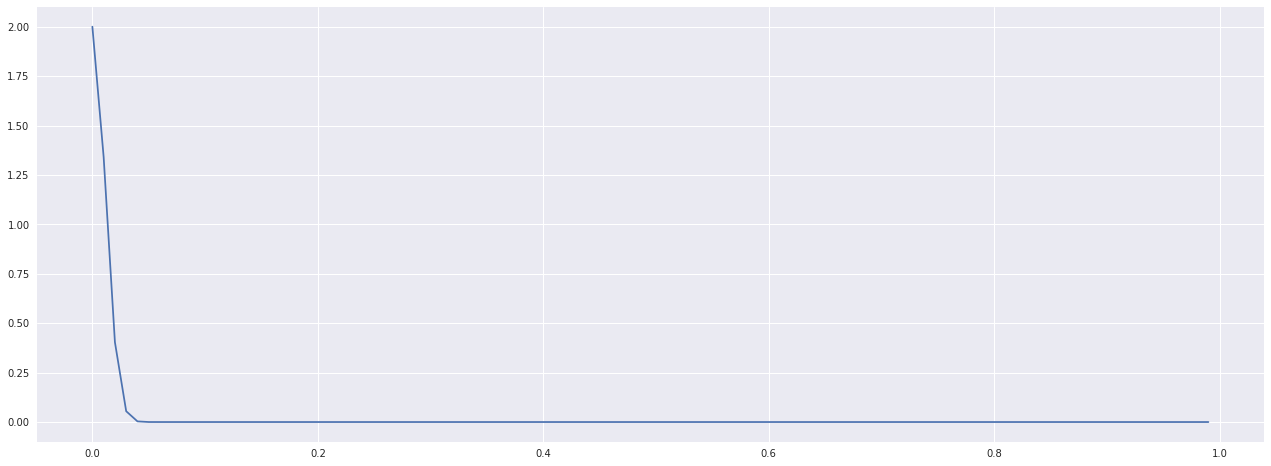

In [41]:

prob_epsilon=[]
epsilons = np.arange(0, 1, 0.01)

N = len(X)
print("N:", N)

#    for e in epsilons:
#        prob_epsilon.append(len([1 for i in dist if abs(i-0.5) > e])/len(dist))
    
plt.figure()
#plt.plot(epsilons, prob_epsilon)
plt.plot(epsilons, [2*math.exp(-2*e**2*N) for e in epsilons])
#plt.title(titles[d])
plt.show

**TBD**